In [1]:
import torch
import torchvision
import os
import glob
import cv2
import numpy as np
from PIL import Image
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF

In [2]:
import torch.nn as nn
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.ConvBlock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), #inplace=True can slightly reduce memory usage
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.ConvBlock(x)
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.ConvBlock = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        s = self.ConvBlock(x) #skip connection
        p = self.pool(s) #pass maxpool2d to next layer of network
        return (p, s)
    
#decoder just for autoencoder, change for UNet
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(out_channels, out_channels)

    def forward(self, p):
        x = self.upConv(p)
        return self.ConvBlock(x)
    
#decoder for UNet
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(in_channels, out_channels)

    def forward(self, p, s):
        x = self.upConv(p)
        x = torch.cat([x, s], dim=1)
        return self.ConvBlock(x)

In [3]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder1 = EncoderBlock(1, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        
        # Decoder
        self.decoder1 = DecoderBlock(1024, 512)
        self.decoder2 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder4 = DecoderBlock(128, 64)
        
        # Final Layer
        self.decoded = nn.Sequential(nn.Conv2d(64, 1, 3, padding=1),
                                     nn.Sigmoid()
                                    )
    def forward(self, x):
        p1, s1 = self.encoder1(x)
        p2, s2 = self.encoder2(p1)
        p3, s3 = self.encoder3(p2)
        p4, s4 = self.encoder4(p3)
        
        b = self.bottleneck(p4)
        
        d1 = self.decoder1(b)
        d2 = self.decoder2(d1)
        d3 = self.decoder3(d2)
        d4 = self.decoder4(d3)
        
        decoded = self.decoded(d4)
        
        return decoded

In [4]:
trainedAE = torch.load("/project/trlab/AE_NormalizedImages_04LR.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(trainedAE)

AE(
  (encoder1): EncoderBlock(
    (ConvBlock): ConvBlock(
      (ConvBlock): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): EncoderBlock(
    (ConvBlock): ConvBlock(
      (ConvBlock): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2

In [5]:
#trainedAE.decoder[0].weight
#for name, param in trainedAE.named_parameters():
#    print(name)

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Encoder
        self.encoder1 = EncoderBlock(1, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        
        # Decoder
        self.decoder1 = UpBlock(1024, 512)
        self.decoder2 = UpBlock(512, 256)
        self.decoder3 = UpBlock(256, 128)
        self.decoder4 = UpBlock(128, 64)
        
        # Final Layer, take out sigmoid if using BCEWithLogitsLoss
        self.decoded = nn.Sequential(nn.Conv2d(64, 1, 1)
                                     #nn.Sigmoid()
                                    )
        
        
    def forward(self, x):
        p1, s1 = self.encoder1(x)
        p2, s2 = self.encoder2(p1)
        p3, s3 = self.encoder3(p2)
        p4, s4 = self.encoder4(p3)
        
        b = self.bottleneck(p4)
        
        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        decoded = self.decoded(d4)
        
        return decoded

In [7]:
# custom loss functions from
# https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388#:~:text=Dice%20Coefficient&text=Dice%20coefficient%20is%20a%20measure,while%200%20indicates%20no%20overlap.&text=Dice%20Loss%20%3D%201%20%E2%80%94%20Dice%20Coefficient.
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    # add sigmoid since we take it out to use BCEWithLogitsLoss
    dicescore = dice_loss(nn.functional.sigmoid(inputs), target)
    bcescore = nn.BCEWithLogitsLoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [8]:
# initialize model
model = UNet()
model.to(device)
 
# Validation using MSE Loss function
loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 3e-4,
                             weight_decay = 1e-8
                            )

# transfer weights from pretrained AE to UNet
params1 = trainedAE.named_parameters()
params2 = model.named_parameters()

dict_params2 = dict(params2)

for name1, param1 in params1:
    if name1 == "decoder1.upConv.weight":
        break
    if name1 in dict_params2:
        dict_params2[name1].data.copy_(param1.data)

In [9]:
# sanity check the models have the same parameters for the encoder block
trainedAE.encoder1.ConvBlock.ConvBlock[0].weight == model.encoder1.ConvBlock.ConvBlock[0].weight

tensor([[[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],


In [10]:
# pathway for image folder
imagePath = "/project/trlab/imagePath"
maskPath = "/project/trlab/maskPath"

# try with single image
#imagePath = "/project/trlab/SingleIm"
#maskPath = "/project/trlab/SingleMask"

imagePaths = []
maskPaths = []
for data_path in sorted(glob.glob(imagePath + '/*')):
    imagePaths.append(data_path)
    
for data_path in sorted(glob.glob(maskPath + '/*')):
    maskPaths.append(data_path)
    
#print(imagePaths)
#print(maskPaths)

In [11]:
# Create Dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imagePaths, maskPaths):
        # init method takes list of image paths, ground truth masks, and transformations as input
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        
    def transform(self, image, mask):
        # standardize to values between 0 and 1 for faster convergence
        image = image/255.0
        image = image.astype('float32')
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Transfer to device
        image = image.to(device)
        mask = mask.to(device)
        
        # Random crop
        i, j, h, w = T.RandomCrop.get_params(image, output_size=(512, 512))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        # Random rotation
        if random.random() > 0.5:
            angle = random.randint(-90,90)
            image = TF.rotate(image,angle)
            mask = TF.rotate(mask,angle)
            
        # Random Gaussian Blur
        if random.random() > 0.5:
            image = TF.gaussian_blur(image, 3, 0.15)
            
        # Random sharpness
        sharpness = random.random()
        shift = random.uniform(0.2,1.8)
        if sharpness > 0.5:
            image = TF.adjust_sharpness(image, shift)
            
        # Random contrast not sure why this isn't working, current documentation says one channel tensors are fine
        # but it's throwing an error saying you need 3 channels
        #contrast = random.random()
        #if contrast > 0.5:
        #    image = TF.adjust_contrast(image, 2)
        #elif contrast < 0.25:
        #    image = TF.adjust_contrast(image, 0.5)
        
        # Random brightness
        brightness = random.random()
        shift = random.uniform(0.2,1.8)
        if brightness > 0.5:
            image = TF.adjust_brightness(image, shift)
            
        # Random Affine
        shearx = random.randint(-45,45)
        sheary = random.randint(-45,45)
        transx = random.randint(-20,20)
        transy = random.randint(-20,20)
        if random.random() > 0.5:
            image = TF.affine(image, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            mask = TF.affine(mask, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            
        #image = image.type('torch.HalfTensor')
        #mask = image.type('torch.HalfTensor')

        return image, mask
    
    def __len__(self):
        # total number of image paths in dataset
        return len(self.imagePaths)
    
    def __getitem__(self,idx):
        # returns sample from dataset
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]
        
        image = cv2.imdecode(np.fromfile(imagePath, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imdecode(np.fromfile(maskPath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

        # use RandomChoice with only ony composed transform so it applies the same way to both
        #transform = T.RandomChoice([T.Compose([T.AutoAugment(T.AutoAugmentPolicy.IMAGENET), T.ToTensor()])])
        image, mask = self.transform(image, mask)
            
        return (image, mask)

In [12]:
# from torchvision import datasets
torch.manual_seed(1)

dataset = Dataset(imagePaths = imagePaths,
                  maskPaths = maskPaths
                 )

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = 4,
                                     shuffle = True)
test_dataset.indices
train_dataset.indices

[0, 10, 2, 3, 7, 6, 4, 8, 1]

In [13]:
# sanity check to see if images were paired with correct mask
#batch1 = next(iter(loader))
#plt.imshow(batch1[0][0].squeeze().numpy().astype('float'))
#plt.show()
#print(batch1[0].shape)

In [14]:
# sanity check continued
#plt.imshow(batch1[1][0].squeeze().numpy().astype('float'))
#plt.show()

In [15]:
epochs = 48000
count = 1
outputs = []
losses = []
#test_losses = []

# modify training loop to use automatic mixed precision

# convert model to half precision to save memory
#model.half()

# need to keep batch norm layers at fp32
#for layer in model.modules():
#    if isinstance(layer, nn.BatchNorm2d):
#        layer.float()

scaler = torch.cuda.amp.GradScaler(enabled=True)
    
model.train()
for epoch in range(epochs):
    runningLoss = 0
    for (i,(image, mask)) in enumerate(loader):
        
        image = image.to(device)
        mask = mask.to(device)
        
        with torch.cuda.amp.autocast():
            # Output of UNet
            reconstructed = model(image)
       
            # Calculating the loss function
            #loss = loss_function(reconstructed, mask)
            #loss = dice_loss(reconstructed, mask)
            loss = bce_dice_loss(reconstructed, mask)
            runningLoss = runningLoss + loss.item()
            
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        # autocast backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
       
    # Storing the losses in a list for plotting
    losses.append(runningLoss/len(loader))
    outputs.append((epochs, image, reconstructed))
    print("epoch", count, "finished")
    count = count + 1

/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished
epoch 16 finished
epoch 17 finished
epoch 18 finished
epoch 19 finished
epoch 20 finished
epoch 21 finished
epoch 22 finished
epoch 23 finished
epoch 24 finished
epoch 25 finished
epoch 26 finished
epoch 27 finished
epoch 28 finished
epoch 29 finished
epoch 30 finished
epoch 31 finished
epoch 32 finished
epoch 33 finished
epoch 34 finished
epoch 35 finished
epoch 36 finished
epoch 37 finished
epoch 38 finished
epoch 39 finished
epoch 40 finished
epoch 41 finished
epoch 42 finished
epoch 43 finished
epoch 44 finished
epoch 45 finished
epoch 46 finished
epoch 47 finished
epoch 48 finished
epoch 49 finished
epoch 50 finished
epoch 51 finished
epoch 52 finished
epoch 53 finished
epoch 54 finished
epoch 55 finished
epoch 56 finished
e

epoch 438 finished
epoch 439 finished
epoch 440 finished
epoch 441 finished
epoch 442 finished
epoch 443 finished
epoch 444 finished
epoch 445 finished
epoch 446 finished
epoch 447 finished
epoch 448 finished
epoch 449 finished
epoch 450 finished
epoch 451 finished
epoch 452 finished
epoch 453 finished
epoch 454 finished
epoch 455 finished
epoch 456 finished
epoch 457 finished
epoch 458 finished
epoch 459 finished
epoch 460 finished
epoch 461 finished
epoch 462 finished
epoch 463 finished
epoch 464 finished
epoch 465 finished
epoch 466 finished
epoch 467 finished
epoch 468 finished
epoch 469 finished
epoch 470 finished
epoch 471 finished
epoch 472 finished
epoch 473 finished
epoch 474 finished
epoch 475 finished
epoch 476 finished
epoch 477 finished
epoch 478 finished
epoch 479 finished
epoch 480 finished
epoch 481 finished
epoch 482 finished
epoch 483 finished
epoch 484 finished
epoch 485 finished
epoch 486 finished
epoch 487 finished
epoch 488 finished
epoch 489 finished
epoch 490 fi

epoch 870 finished
epoch 871 finished
epoch 872 finished
epoch 873 finished
epoch 874 finished
epoch 875 finished
epoch 876 finished
epoch 877 finished
epoch 878 finished
epoch 879 finished
epoch 880 finished
epoch 881 finished
epoch 882 finished
epoch 883 finished
epoch 884 finished
epoch 885 finished
epoch 886 finished
epoch 887 finished
epoch 888 finished
epoch 889 finished
epoch 890 finished
epoch 891 finished
epoch 892 finished
epoch 893 finished
epoch 894 finished
epoch 895 finished
epoch 896 finished
epoch 897 finished
epoch 898 finished
epoch 899 finished
epoch 900 finished
epoch 901 finished
epoch 902 finished
epoch 903 finished
epoch 904 finished
epoch 905 finished
epoch 906 finished
epoch 907 finished
epoch 908 finished
epoch 909 finished
epoch 910 finished
epoch 911 finished
epoch 912 finished
epoch 913 finished
epoch 914 finished
epoch 915 finished
epoch 916 finished
epoch 917 finished
epoch 918 finished
epoch 919 finished
epoch 920 finished
epoch 921 finished
epoch 922 fi

epoch 1287 finished
epoch 1288 finished
epoch 1289 finished
epoch 1290 finished
epoch 1291 finished
epoch 1292 finished
epoch 1293 finished
epoch 1294 finished
epoch 1295 finished
epoch 1296 finished
epoch 1297 finished
epoch 1298 finished
epoch 1299 finished
epoch 1300 finished
epoch 1301 finished
epoch 1302 finished
epoch 1303 finished
epoch 1304 finished
epoch 1305 finished
epoch 1306 finished
epoch 1307 finished
epoch 1308 finished
epoch 1309 finished
epoch 1310 finished
epoch 1311 finished
epoch 1312 finished
epoch 1313 finished
epoch 1314 finished
epoch 1315 finished
epoch 1316 finished
epoch 1317 finished
epoch 1318 finished
epoch 1319 finished
epoch 1320 finished
epoch 1321 finished
epoch 1322 finished
epoch 1323 finished
epoch 1324 finished
epoch 1325 finished
epoch 1326 finished
epoch 1327 finished
epoch 1328 finished
epoch 1329 finished
epoch 1330 finished
epoch 1331 finished
epoch 1332 finished
epoch 1333 finished
epoch 1334 finished
epoch 1335 finished
epoch 1336 finished


epoch 1697 finished
epoch 1698 finished
epoch 1699 finished
epoch 1700 finished
epoch 1701 finished
epoch 1702 finished
epoch 1703 finished
epoch 1704 finished
epoch 1705 finished
epoch 1706 finished
epoch 1707 finished
epoch 1708 finished
epoch 1709 finished
epoch 1710 finished
epoch 1711 finished
epoch 1712 finished
epoch 1713 finished
epoch 1714 finished
epoch 1715 finished
epoch 1716 finished
epoch 1717 finished
epoch 1718 finished
epoch 1719 finished
epoch 1720 finished
epoch 1721 finished
epoch 1722 finished
epoch 1723 finished
epoch 1724 finished
epoch 1725 finished
epoch 1726 finished
epoch 1727 finished
epoch 1728 finished
epoch 1729 finished
epoch 1730 finished
epoch 1731 finished
epoch 1732 finished
epoch 1733 finished
epoch 1734 finished
epoch 1735 finished
epoch 1736 finished
epoch 1737 finished
epoch 1738 finished
epoch 1739 finished
epoch 1740 finished
epoch 1741 finished
epoch 1742 finished
epoch 1743 finished
epoch 1744 finished
epoch 1745 finished
epoch 1746 finished


epoch 2107 finished
epoch 2108 finished
epoch 2109 finished
epoch 2110 finished
epoch 2111 finished
epoch 2112 finished
epoch 2113 finished
epoch 2114 finished
epoch 2115 finished
epoch 2116 finished
epoch 2117 finished
epoch 2118 finished
epoch 2119 finished
epoch 2120 finished
epoch 2121 finished
epoch 2122 finished
epoch 2123 finished
epoch 2124 finished
epoch 2125 finished
epoch 2126 finished
epoch 2127 finished
epoch 2128 finished
epoch 2129 finished
epoch 2130 finished
epoch 2131 finished
epoch 2132 finished
epoch 2133 finished
epoch 2134 finished
epoch 2135 finished
epoch 2136 finished
epoch 2137 finished
epoch 2138 finished
epoch 2139 finished
epoch 2140 finished
epoch 2141 finished
epoch 2142 finished
epoch 2143 finished
epoch 2144 finished
epoch 2145 finished
epoch 2146 finished
epoch 2147 finished
epoch 2148 finished
epoch 2149 finished
epoch 2150 finished
epoch 2151 finished
epoch 2152 finished
epoch 2153 finished
epoch 2154 finished
epoch 2155 finished
epoch 2156 finished


epoch 2517 finished
epoch 2518 finished
epoch 2519 finished
epoch 2520 finished
epoch 2521 finished
epoch 2522 finished
epoch 2523 finished
epoch 2524 finished
epoch 2525 finished
epoch 2526 finished
epoch 2527 finished
epoch 2528 finished
epoch 2529 finished
epoch 2530 finished
epoch 2531 finished
epoch 2532 finished
epoch 2533 finished
epoch 2534 finished
epoch 2535 finished
epoch 2536 finished
epoch 2537 finished
epoch 2538 finished
epoch 2539 finished
epoch 2540 finished
epoch 2541 finished
epoch 2542 finished
epoch 2543 finished
epoch 2544 finished
epoch 2545 finished
epoch 2546 finished
epoch 2547 finished
epoch 2548 finished
epoch 2549 finished
epoch 2550 finished
epoch 2551 finished
epoch 2552 finished
epoch 2553 finished
epoch 2554 finished
epoch 2555 finished
epoch 2556 finished
epoch 2557 finished
epoch 2558 finished
epoch 2559 finished
epoch 2560 finished
epoch 2561 finished
epoch 2562 finished
epoch 2563 finished
epoch 2564 finished
epoch 2565 finished
epoch 2566 finished


epoch 2927 finished
epoch 2928 finished
epoch 2929 finished
epoch 2930 finished
epoch 2931 finished
epoch 2932 finished
epoch 2933 finished
epoch 2934 finished
epoch 2935 finished
epoch 2936 finished
epoch 2937 finished
epoch 2938 finished
epoch 2939 finished
epoch 2940 finished
epoch 2941 finished
epoch 2942 finished
epoch 2943 finished
epoch 2944 finished
epoch 2945 finished
epoch 2946 finished
epoch 2947 finished
epoch 2948 finished
epoch 2949 finished
epoch 2950 finished
epoch 2951 finished
epoch 2952 finished
epoch 2953 finished
epoch 2954 finished
epoch 2955 finished
epoch 2956 finished
epoch 2957 finished
epoch 2958 finished
epoch 2959 finished
epoch 2960 finished
epoch 2961 finished
epoch 2962 finished
epoch 2963 finished
epoch 2964 finished
epoch 2965 finished
epoch 2966 finished
epoch 2967 finished
epoch 2968 finished
epoch 2969 finished
epoch 2970 finished
epoch 2971 finished
epoch 2972 finished
epoch 2973 finished
epoch 2974 finished
epoch 2975 finished
epoch 2976 finished


epoch 3337 finished
epoch 3338 finished
epoch 3339 finished
epoch 3340 finished
epoch 3341 finished
epoch 3342 finished
epoch 3343 finished
epoch 3344 finished
epoch 3345 finished
epoch 3346 finished
epoch 3347 finished
epoch 3348 finished
epoch 3349 finished
epoch 3350 finished
epoch 3351 finished
epoch 3352 finished
epoch 3353 finished
epoch 3354 finished
epoch 3355 finished
epoch 3356 finished
epoch 3357 finished
epoch 3358 finished
epoch 3359 finished
epoch 3360 finished
epoch 3361 finished
epoch 3362 finished
epoch 3363 finished
epoch 3364 finished
epoch 3365 finished
epoch 3366 finished
epoch 3367 finished
epoch 3368 finished
epoch 3369 finished
epoch 3370 finished
epoch 3371 finished
epoch 3372 finished
epoch 3373 finished
epoch 3374 finished
epoch 3375 finished
epoch 3376 finished
epoch 3377 finished
epoch 3378 finished
epoch 3379 finished
epoch 3380 finished
epoch 3381 finished
epoch 3382 finished
epoch 3383 finished
epoch 3384 finished
epoch 3385 finished
epoch 3386 finished


epoch 3747 finished
epoch 3748 finished
epoch 3749 finished
epoch 3750 finished
epoch 3751 finished
epoch 3752 finished
epoch 3753 finished
epoch 3754 finished
epoch 3755 finished
epoch 3756 finished
epoch 3757 finished
epoch 3758 finished
epoch 3759 finished
epoch 3760 finished
epoch 3761 finished
epoch 3762 finished
epoch 3763 finished
epoch 3764 finished
epoch 3765 finished
epoch 3766 finished
epoch 3767 finished
epoch 3768 finished
epoch 3769 finished
epoch 3770 finished
epoch 3771 finished
epoch 3772 finished
epoch 3773 finished
epoch 3774 finished
epoch 3775 finished
epoch 3776 finished
epoch 3777 finished
epoch 3778 finished
epoch 3779 finished
epoch 3780 finished
epoch 3781 finished
epoch 3782 finished
epoch 3783 finished
epoch 3784 finished
epoch 3785 finished
epoch 3786 finished
epoch 3787 finished
epoch 3788 finished
epoch 3789 finished
epoch 3790 finished
epoch 3791 finished
epoch 3792 finished
epoch 3793 finished
epoch 3794 finished
epoch 3795 finished
epoch 3796 finished


epoch 4157 finished
epoch 4158 finished
epoch 4159 finished
epoch 4160 finished
epoch 4161 finished
epoch 4162 finished
epoch 4163 finished
epoch 4164 finished
epoch 4165 finished
epoch 4166 finished
epoch 4167 finished
epoch 4168 finished
epoch 4169 finished
epoch 4170 finished
epoch 4171 finished
epoch 4172 finished
epoch 4173 finished
epoch 4174 finished
epoch 4175 finished
epoch 4176 finished
epoch 4177 finished
epoch 4178 finished
epoch 4179 finished
epoch 4180 finished
epoch 4181 finished
epoch 4182 finished
epoch 4183 finished
epoch 4184 finished
epoch 4185 finished
epoch 4186 finished
epoch 4187 finished
epoch 4188 finished
epoch 4189 finished
epoch 4190 finished
epoch 4191 finished
epoch 4192 finished
epoch 4193 finished
epoch 4194 finished
epoch 4195 finished
epoch 4196 finished
epoch 4197 finished
epoch 4198 finished
epoch 4199 finished
epoch 4200 finished
epoch 4201 finished
epoch 4202 finished
epoch 4203 finished
epoch 4204 finished
epoch 4205 finished
epoch 4206 finished


epoch 4567 finished
epoch 4568 finished
epoch 4569 finished
epoch 4570 finished
epoch 4571 finished
epoch 4572 finished
epoch 4573 finished
epoch 4574 finished
epoch 4575 finished
epoch 4576 finished
epoch 4577 finished
epoch 4578 finished
epoch 4579 finished
epoch 4580 finished
epoch 4581 finished
epoch 4582 finished
epoch 4583 finished
epoch 4584 finished
epoch 4585 finished
epoch 4586 finished
epoch 4587 finished
epoch 4588 finished
epoch 4589 finished
epoch 4590 finished
epoch 4591 finished
epoch 4592 finished
epoch 4593 finished
epoch 4594 finished
epoch 4595 finished
epoch 4596 finished
epoch 4597 finished
epoch 4598 finished
epoch 4599 finished
epoch 4600 finished
epoch 4601 finished
epoch 4602 finished
epoch 4603 finished
epoch 4604 finished
epoch 4605 finished
epoch 4606 finished
epoch 4607 finished
epoch 4608 finished
epoch 4609 finished
epoch 4610 finished
epoch 4611 finished
epoch 4612 finished
epoch 4613 finished
epoch 4614 finished
epoch 4615 finished
epoch 4616 finished


epoch 4977 finished
epoch 4978 finished
epoch 4979 finished
epoch 4980 finished
epoch 4981 finished
epoch 4982 finished
epoch 4983 finished
epoch 4984 finished
epoch 4985 finished
epoch 4986 finished
epoch 4987 finished
epoch 4988 finished
epoch 4989 finished
epoch 4990 finished
epoch 4991 finished
epoch 4992 finished
epoch 4993 finished
epoch 4994 finished
epoch 4995 finished
epoch 4996 finished
epoch 4997 finished
epoch 4998 finished
epoch 4999 finished
epoch 5000 finished
epoch 5001 finished
epoch 5002 finished
epoch 5003 finished
epoch 5004 finished
epoch 5005 finished
epoch 5006 finished
epoch 5007 finished
epoch 5008 finished
epoch 5009 finished
epoch 5010 finished
epoch 5011 finished
epoch 5012 finished
epoch 5013 finished
epoch 5014 finished
epoch 5015 finished
epoch 5016 finished
epoch 5017 finished
epoch 5018 finished
epoch 5019 finished
epoch 5020 finished
epoch 5021 finished
epoch 5022 finished
epoch 5023 finished
epoch 5024 finished
epoch 5025 finished
epoch 5026 finished


epoch 5387 finished
epoch 5388 finished
epoch 5389 finished
epoch 5390 finished
epoch 5391 finished
epoch 5392 finished
epoch 5393 finished
epoch 5394 finished
epoch 5395 finished
epoch 5396 finished
epoch 5397 finished
epoch 5398 finished
epoch 5399 finished
epoch 5400 finished
epoch 5401 finished
epoch 5402 finished
epoch 5403 finished
epoch 5404 finished
epoch 5405 finished
epoch 5406 finished
epoch 5407 finished
epoch 5408 finished
epoch 5409 finished
epoch 5410 finished
epoch 5411 finished
epoch 5412 finished
epoch 5413 finished
epoch 5414 finished
epoch 5415 finished
epoch 5416 finished
epoch 5417 finished
epoch 5418 finished
epoch 5419 finished
epoch 5420 finished
epoch 5421 finished
epoch 5422 finished
epoch 5423 finished
epoch 5424 finished
epoch 5425 finished
epoch 5426 finished
epoch 5427 finished
epoch 5428 finished
epoch 5429 finished
epoch 5430 finished
epoch 5431 finished
epoch 5432 finished
epoch 5433 finished
epoch 5434 finished
epoch 5435 finished
epoch 5436 finished


epoch 5797 finished
epoch 5798 finished
epoch 5799 finished
epoch 5800 finished
epoch 5801 finished
epoch 5802 finished
epoch 5803 finished
epoch 5804 finished
epoch 5805 finished
epoch 5806 finished
epoch 5807 finished
epoch 5808 finished
epoch 5809 finished
epoch 5810 finished
epoch 5811 finished
epoch 5812 finished
epoch 5813 finished
epoch 5814 finished
epoch 5815 finished
epoch 5816 finished
epoch 5817 finished
epoch 5818 finished
epoch 5819 finished
epoch 5820 finished
epoch 5821 finished
epoch 5822 finished
epoch 5823 finished
epoch 5824 finished
epoch 5825 finished
epoch 5826 finished
epoch 5827 finished
epoch 5828 finished
epoch 5829 finished
epoch 5830 finished
epoch 5831 finished
epoch 5832 finished
epoch 5833 finished
epoch 5834 finished
epoch 5835 finished
epoch 5836 finished
epoch 5837 finished
epoch 5838 finished
epoch 5839 finished
epoch 5840 finished
epoch 5841 finished
epoch 5842 finished
epoch 5843 finished
epoch 5844 finished
epoch 5845 finished
epoch 5846 finished


epoch 6207 finished
epoch 6208 finished
epoch 6209 finished
epoch 6210 finished
epoch 6211 finished
epoch 6212 finished
epoch 6213 finished
epoch 6214 finished
epoch 6215 finished
epoch 6216 finished
epoch 6217 finished
epoch 6218 finished
epoch 6219 finished
epoch 6220 finished
epoch 6221 finished
epoch 6222 finished
epoch 6223 finished
epoch 6224 finished
epoch 6225 finished
epoch 6226 finished
epoch 6227 finished
epoch 6228 finished
epoch 6229 finished
epoch 6230 finished
epoch 6231 finished
epoch 6232 finished
epoch 6233 finished
epoch 6234 finished
epoch 6235 finished
epoch 6236 finished
epoch 6237 finished
epoch 6238 finished
epoch 6239 finished
epoch 6240 finished
epoch 6241 finished
epoch 6242 finished
epoch 6243 finished
epoch 6244 finished
epoch 6245 finished
epoch 6246 finished
epoch 6247 finished
epoch 6248 finished
epoch 6249 finished
epoch 6250 finished
epoch 6251 finished
epoch 6252 finished
epoch 6253 finished
epoch 6254 finished
epoch 6255 finished
epoch 6256 finished


epoch 6617 finished
epoch 6618 finished
epoch 6619 finished
epoch 6620 finished
epoch 6621 finished
epoch 6622 finished
epoch 6623 finished
epoch 6624 finished
epoch 6625 finished
epoch 6626 finished
epoch 6627 finished
epoch 6628 finished
epoch 6629 finished
epoch 6630 finished
epoch 6631 finished
epoch 6632 finished
epoch 6633 finished
epoch 6634 finished
epoch 6635 finished
epoch 6636 finished
epoch 6637 finished
epoch 6638 finished
epoch 6639 finished
epoch 6640 finished
epoch 6641 finished
epoch 6642 finished
epoch 6643 finished
epoch 6644 finished
epoch 6645 finished
epoch 6646 finished
epoch 6647 finished
epoch 6648 finished
epoch 6649 finished
epoch 6650 finished
epoch 6651 finished
epoch 6652 finished
epoch 6653 finished
epoch 6654 finished
epoch 6655 finished
epoch 6656 finished
epoch 6657 finished
epoch 6658 finished
epoch 6659 finished
epoch 6660 finished
epoch 6661 finished
epoch 6662 finished
epoch 6663 finished
epoch 6664 finished
epoch 6665 finished
epoch 6666 finished


epoch 7027 finished
epoch 7028 finished
epoch 7029 finished
epoch 7030 finished
epoch 7031 finished
epoch 7032 finished
epoch 7033 finished
epoch 7034 finished
epoch 7035 finished
epoch 7036 finished
epoch 7037 finished
epoch 7038 finished
epoch 7039 finished
epoch 7040 finished
epoch 7041 finished
epoch 7042 finished
epoch 7043 finished
epoch 7044 finished
epoch 7045 finished
epoch 7046 finished
epoch 7047 finished
epoch 7048 finished
epoch 7049 finished
epoch 7050 finished
epoch 7051 finished
epoch 7052 finished
epoch 7053 finished
epoch 7054 finished
epoch 7055 finished
epoch 7056 finished
epoch 7057 finished
epoch 7058 finished
epoch 7059 finished
epoch 7060 finished
epoch 7061 finished
epoch 7062 finished
epoch 7063 finished
epoch 7064 finished
epoch 7065 finished
epoch 7066 finished
epoch 7067 finished
epoch 7068 finished
epoch 7069 finished
epoch 7070 finished
epoch 7071 finished
epoch 7072 finished
epoch 7073 finished
epoch 7074 finished
epoch 7075 finished
epoch 7076 finished


epoch 7437 finished
epoch 7438 finished
epoch 7439 finished
epoch 7440 finished
epoch 7441 finished
epoch 7442 finished
epoch 7443 finished
epoch 7444 finished
epoch 7445 finished
epoch 7446 finished
epoch 7447 finished
epoch 7448 finished
epoch 7449 finished
epoch 7450 finished
epoch 7451 finished
epoch 7452 finished
epoch 7453 finished
epoch 7454 finished
epoch 7455 finished
epoch 7456 finished
epoch 7457 finished
epoch 7458 finished
epoch 7459 finished
epoch 7460 finished
epoch 7461 finished
epoch 7462 finished
epoch 7463 finished
epoch 7464 finished
epoch 7465 finished
epoch 7466 finished
epoch 7467 finished
epoch 7468 finished
epoch 7469 finished
epoch 7470 finished
epoch 7471 finished
epoch 7472 finished
epoch 7473 finished
epoch 7474 finished
epoch 7475 finished
epoch 7476 finished
epoch 7477 finished
epoch 7478 finished
epoch 7479 finished
epoch 7480 finished
epoch 7481 finished
epoch 7482 finished
epoch 7483 finished
epoch 7484 finished
epoch 7485 finished
epoch 7486 finished


epoch 7847 finished
epoch 7848 finished
epoch 7849 finished
epoch 7850 finished
epoch 7851 finished
epoch 7852 finished
epoch 7853 finished
epoch 7854 finished
epoch 7855 finished
epoch 7856 finished
epoch 7857 finished
epoch 7858 finished
epoch 7859 finished
epoch 7860 finished
epoch 7861 finished
epoch 7862 finished
epoch 7863 finished
epoch 7864 finished
epoch 7865 finished
epoch 7866 finished
epoch 7867 finished
epoch 7868 finished
epoch 7869 finished
epoch 7870 finished
epoch 7871 finished
epoch 7872 finished
epoch 7873 finished
epoch 7874 finished
epoch 7875 finished
epoch 7876 finished
epoch 7877 finished
epoch 7878 finished
epoch 7879 finished
epoch 7880 finished
epoch 7881 finished
epoch 7882 finished
epoch 7883 finished
epoch 7884 finished
epoch 7885 finished
epoch 7886 finished
epoch 7887 finished
epoch 7888 finished
epoch 7889 finished
epoch 7890 finished
epoch 7891 finished
epoch 7892 finished
epoch 7893 finished
epoch 7894 finished
epoch 7895 finished
epoch 7896 finished


epoch 8257 finished
epoch 8258 finished
epoch 8259 finished
epoch 8260 finished
epoch 8261 finished
epoch 8262 finished
epoch 8263 finished
epoch 8264 finished
epoch 8265 finished
epoch 8266 finished
epoch 8267 finished
epoch 8268 finished
epoch 8269 finished
epoch 8270 finished
epoch 8271 finished
epoch 8272 finished
epoch 8273 finished
epoch 8274 finished
epoch 8275 finished
epoch 8276 finished
epoch 8277 finished
epoch 8278 finished
epoch 8279 finished
epoch 8280 finished
epoch 8281 finished
epoch 8282 finished
epoch 8283 finished
epoch 8284 finished
epoch 8285 finished
epoch 8286 finished
epoch 8287 finished
epoch 8288 finished
epoch 8289 finished
epoch 8290 finished
epoch 8291 finished
epoch 8292 finished
epoch 8293 finished
epoch 8294 finished
epoch 8295 finished
epoch 8296 finished
epoch 8297 finished
epoch 8298 finished
epoch 8299 finished
epoch 8300 finished
epoch 8301 finished
epoch 8302 finished
epoch 8303 finished
epoch 8304 finished
epoch 8305 finished
epoch 8306 finished


epoch 8667 finished
epoch 8668 finished
epoch 8669 finished
epoch 8670 finished
epoch 8671 finished
epoch 8672 finished
epoch 8673 finished
epoch 8674 finished
epoch 8675 finished
epoch 8676 finished
epoch 8677 finished
epoch 8678 finished
epoch 8679 finished
epoch 8680 finished
epoch 8681 finished
epoch 8682 finished
epoch 8683 finished
epoch 8684 finished
epoch 8685 finished
epoch 8686 finished
epoch 8687 finished
epoch 8688 finished
epoch 8689 finished
epoch 8690 finished
epoch 8691 finished
epoch 8692 finished
epoch 8693 finished
epoch 8694 finished
epoch 8695 finished
epoch 8696 finished
epoch 8697 finished
epoch 8698 finished
epoch 8699 finished
epoch 8700 finished
epoch 8701 finished
epoch 8702 finished
epoch 8703 finished
epoch 8704 finished
epoch 8705 finished
epoch 8706 finished
epoch 8707 finished
epoch 8708 finished
epoch 8709 finished
epoch 8710 finished
epoch 8711 finished
epoch 8712 finished
epoch 8713 finished
epoch 8714 finished
epoch 8715 finished
epoch 8716 finished


epoch 9077 finished
epoch 9078 finished
epoch 9079 finished
epoch 9080 finished
epoch 9081 finished
epoch 9082 finished
epoch 9083 finished
epoch 9084 finished
epoch 9085 finished
epoch 9086 finished
epoch 9087 finished
epoch 9088 finished
epoch 9089 finished
epoch 9090 finished
epoch 9091 finished
epoch 9092 finished
epoch 9093 finished
epoch 9094 finished
epoch 9095 finished
epoch 9096 finished
epoch 9097 finished
epoch 9098 finished
epoch 9099 finished
epoch 9100 finished
epoch 9101 finished
epoch 9102 finished
epoch 9103 finished
epoch 9104 finished
epoch 9105 finished
epoch 9106 finished
epoch 9107 finished
epoch 9108 finished
epoch 9109 finished
epoch 9110 finished
epoch 9111 finished
epoch 9112 finished
epoch 9113 finished
epoch 9114 finished
epoch 9115 finished
epoch 9116 finished
epoch 9117 finished
epoch 9118 finished
epoch 9119 finished
epoch 9120 finished
epoch 9121 finished
epoch 9122 finished
epoch 9123 finished
epoch 9124 finished
epoch 9125 finished
epoch 9126 finished


epoch 9487 finished
epoch 9488 finished
epoch 9489 finished
epoch 9490 finished
epoch 9491 finished
epoch 9492 finished
epoch 9493 finished
epoch 9494 finished
epoch 9495 finished
epoch 9496 finished
epoch 9497 finished
epoch 9498 finished
epoch 9499 finished
epoch 9500 finished
epoch 9501 finished
epoch 9502 finished
epoch 9503 finished
epoch 9504 finished
epoch 9505 finished
epoch 9506 finished
epoch 9507 finished
epoch 9508 finished
epoch 9509 finished
epoch 9510 finished
epoch 9511 finished
epoch 9512 finished
epoch 9513 finished
epoch 9514 finished
epoch 9515 finished
epoch 9516 finished
epoch 9517 finished
epoch 9518 finished
epoch 9519 finished
epoch 9520 finished
epoch 9521 finished
epoch 9522 finished
epoch 9523 finished
epoch 9524 finished
epoch 9525 finished
epoch 9526 finished
epoch 9527 finished
epoch 9528 finished
epoch 9529 finished
epoch 9530 finished
epoch 9531 finished
epoch 9532 finished
epoch 9533 finished
epoch 9534 finished
epoch 9535 finished
epoch 9536 finished


epoch 9897 finished
epoch 9898 finished
epoch 9899 finished
epoch 9900 finished
epoch 9901 finished
epoch 9902 finished
epoch 9903 finished
epoch 9904 finished
epoch 9905 finished
epoch 9906 finished
epoch 9907 finished
epoch 9908 finished
epoch 9909 finished
epoch 9910 finished
epoch 9911 finished
epoch 9912 finished
epoch 9913 finished
epoch 9914 finished
epoch 9915 finished
epoch 9916 finished
epoch 9917 finished
epoch 9918 finished
epoch 9919 finished
epoch 9920 finished
epoch 9921 finished
epoch 9922 finished
epoch 9923 finished
epoch 9924 finished
epoch 9925 finished
epoch 9926 finished
epoch 9927 finished
epoch 9928 finished
epoch 9929 finished
epoch 9930 finished
epoch 9931 finished
epoch 9932 finished
epoch 9933 finished
epoch 9934 finished
epoch 9935 finished
epoch 9936 finished
epoch 9937 finished
epoch 9938 finished
epoch 9939 finished
epoch 9940 finished
epoch 9941 finished
epoch 9942 finished
epoch 9943 finished
epoch 9944 finished
epoch 9945 finished
epoch 9946 finished


epoch 10293 finished
epoch 10294 finished
epoch 10295 finished
epoch 10296 finished
epoch 10297 finished
epoch 10298 finished
epoch 10299 finished
epoch 10300 finished
epoch 10301 finished
epoch 10302 finished
epoch 10303 finished
epoch 10304 finished
epoch 10305 finished
epoch 10306 finished
epoch 10307 finished
epoch 10308 finished
epoch 10309 finished
epoch 10310 finished
epoch 10311 finished
epoch 10312 finished
epoch 10313 finished
epoch 10314 finished
epoch 10315 finished
epoch 10316 finished
epoch 10317 finished
epoch 10318 finished
epoch 10319 finished
epoch 10320 finished
epoch 10321 finished
epoch 10322 finished
epoch 10323 finished
epoch 10324 finished
epoch 10325 finished
epoch 10326 finished
epoch 10327 finished
epoch 10328 finished
epoch 10329 finished
epoch 10330 finished
epoch 10331 finished
epoch 10332 finished
epoch 10333 finished
epoch 10334 finished
epoch 10335 finished
epoch 10336 finished
epoch 10337 finished
epoch 10338 finished
epoch 10339 finished
epoch 10340 f

epoch 10684 finished
epoch 10685 finished
epoch 10686 finished
epoch 10687 finished
epoch 10688 finished
epoch 10689 finished
epoch 10690 finished
epoch 10691 finished
epoch 10692 finished
epoch 10693 finished
epoch 10694 finished
epoch 10695 finished
epoch 10696 finished
epoch 10697 finished
epoch 10698 finished
epoch 10699 finished
epoch 10700 finished
epoch 10701 finished
epoch 10702 finished
epoch 10703 finished
epoch 10704 finished
epoch 10705 finished
epoch 10706 finished
epoch 10707 finished
epoch 10708 finished
epoch 10709 finished
epoch 10710 finished
epoch 10711 finished
epoch 10712 finished
epoch 10713 finished
epoch 10714 finished
epoch 10715 finished
epoch 10716 finished
epoch 10717 finished
epoch 10718 finished
epoch 10719 finished
epoch 10720 finished
epoch 10721 finished
epoch 10722 finished
epoch 10723 finished
epoch 10724 finished
epoch 10725 finished
epoch 10726 finished
epoch 10727 finished
epoch 10728 finished
epoch 10729 finished
epoch 10730 finished
epoch 10731 f

epoch 11075 finished
epoch 11076 finished
epoch 11077 finished
epoch 11078 finished
epoch 11079 finished
epoch 11080 finished
epoch 11081 finished
epoch 11082 finished
epoch 11083 finished
epoch 11084 finished
epoch 11085 finished
epoch 11086 finished
epoch 11087 finished
epoch 11088 finished
epoch 11089 finished
epoch 11090 finished
epoch 11091 finished
epoch 11092 finished
epoch 11093 finished
epoch 11094 finished
epoch 11095 finished
epoch 11096 finished
epoch 11097 finished
epoch 11098 finished
epoch 11099 finished
epoch 11100 finished
epoch 11101 finished
epoch 11102 finished
epoch 11103 finished
epoch 11104 finished
epoch 11105 finished
epoch 11106 finished
epoch 11107 finished
epoch 11108 finished
epoch 11109 finished
epoch 11110 finished
epoch 11111 finished
epoch 11112 finished
epoch 11113 finished
epoch 11114 finished
epoch 11115 finished
epoch 11116 finished
epoch 11117 finished
epoch 11118 finished
epoch 11119 finished
epoch 11120 finished
epoch 11121 finished
epoch 11122 f

epoch 11466 finished
epoch 11467 finished
epoch 11468 finished
epoch 11469 finished
epoch 11470 finished
epoch 11471 finished
epoch 11472 finished
epoch 11473 finished
epoch 11474 finished
epoch 11475 finished
epoch 11476 finished
epoch 11477 finished
epoch 11478 finished
epoch 11479 finished
epoch 11480 finished
epoch 11481 finished
epoch 11482 finished
epoch 11483 finished
epoch 11484 finished
epoch 11485 finished
epoch 11486 finished
epoch 11487 finished
epoch 11488 finished
epoch 11489 finished
epoch 11490 finished
epoch 11491 finished
epoch 11492 finished
epoch 11493 finished
epoch 11494 finished
epoch 11495 finished
epoch 11496 finished
epoch 11497 finished
epoch 11498 finished
epoch 11499 finished
epoch 11500 finished
epoch 11501 finished
epoch 11502 finished
epoch 11503 finished
epoch 11504 finished
epoch 11505 finished
epoch 11506 finished
epoch 11507 finished
epoch 11508 finished
epoch 11509 finished
epoch 11510 finished
epoch 11511 finished
epoch 11512 finished
epoch 11513 f

epoch 11857 finished
epoch 11858 finished
epoch 11859 finished
epoch 11860 finished
epoch 11861 finished
epoch 11862 finished
epoch 11863 finished
epoch 11864 finished
epoch 11865 finished
epoch 11866 finished
epoch 11867 finished
epoch 11868 finished
epoch 11869 finished
epoch 11870 finished
epoch 11871 finished
epoch 11872 finished
epoch 11873 finished
epoch 11874 finished
epoch 11875 finished
epoch 11876 finished
epoch 11877 finished
epoch 11878 finished
epoch 11879 finished
epoch 11880 finished
epoch 11881 finished
epoch 11882 finished
epoch 11883 finished
epoch 11884 finished
epoch 11885 finished
epoch 11886 finished
epoch 11887 finished
epoch 11888 finished
epoch 11889 finished
epoch 11890 finished
epoch 11891 finished
epoch 11892 finished
epoch 11893 finished
epoch 11894 finished
epoch 11895 finished
epoch 11896 finished
epoch 11897 finished
epoch 11898 finished
epoch 11899 finished
epoch 11900 finished
epoch 11901 finished
epoch 11902 finished
epoch 11903 finished
epoch 11904 f

epoch 12248 finished
epoch 12249 finished
epoch 12250 finished
epoch 12251 finished
epoch 12252 finished
epoch 12253 finished
epoch 12254 finished
epoch 12255 finished
epoch 12256 finished
epoch 12257 finished
epoch 12258 finished
epoch 12259 finished
epoch 12260 finished
epoch 12261 finished
epoch 12262 finished
epoch 12263 finished
epoch 12264 finished
epoch 12265 finished
epoch 12266 finished
epoch 12267 finished
epoch 12268 finished
epoch 12269 finished
epoch 12270 finished
epoch 12271 finished
epoch 12272 finished
epoch 12273 finished
epoch 12274 finished
epoch 12275 finished
epoch 12276 finished
epoch 12277 finished
epoch 12278 finished
epoch 12279 finished
epoch 12280 finished
epoch 12281 finished
epoch 12282 finished
epoch 12283 finished
epoch 12284 finished
epoch 12285 finished
epoch 12286 finished
epoch 12287 finished
epoch 12288 finished
epoch 12289 finished
epoch 12290 finished
epoch 12291 finished
epoch 12292 finished
epoch 12293 finished
epoch 12294 finished
epoch 12295 f

epoch 12639 finished
epoch 12640 finished
epoch 12641 finished
epoch 12642 finished
epoch 12643 finished
epoch 12644 finished
epoch 12645 finished
epoch 12646 finished
epoch 12647 finished
epoch 12648 finished
epoch 12649 finished
epoch 12650 finished
epoch 12651 finished
epoch 12652 finished
epoch 12653 finished
epoch 12654 finished
epoch 12655 finished
epoch 12656 finished
epoch 12657 finished
epoch 12658 finished
epoch 12659 finished
epoch 12660 finished
epoch 12661 finished
epoch 12662 finished
epoch 12663 finished
epoch 12664 finished
epoch 12665 finished
epoch 12666 finished
epoch 12667 finished
epoch 12668 finished
epoch 12669 finished
epoch 12670 finished
epoch 12671 finished
epoch 12672 finished
epoch 12673 finished
epoch 12674 finished
epoch 12675 finished
epoch 12676 finished
epoch 12677 finished
epoch 12678 finished
epoch 12679 finished
epoch 12680 finished
epoch 12681 finished
epoch 12682 finished
epoch 12683 finished
epoch 12684 finished
epoch 12685 finished
epoch 12686 f

epoch 13030 finished
epoch 13031 finished
epoch 13032 finished
epoch 13033 finished
epoch 13034 finished
epoch 13035 finished
epoch 13036 finished
epoch 13037 finished
epoch 13038 finished
epoch 13039 finished
epoch 13040 finished
epoch 13041 finished
epoch 13042 finished
epoch 13043 finished
epoch 13044 finished
epoch 13045 finished
epoch 13046 finished
epoch 13047 finished
epoch 13048 finished
epoch 13049 finished
epoch 13050 finished
epoch 13051 finished
epoch 13052 finished
epoch 13053 finished
epoch 13054 finished
epoch 13055 finished
epoch 13056 finished
epoch 13057 finished
epoch 13058 finished
epoch 13059 finished
epoch 13060 finished
epoch 13061 finished
epoch 13062 finished
epoch 13063 finished
epoch 13064 finished
epoch 13065 finished
epoch 13066 finished
epoch 13067 finished
epoch 13068 finished
epoch 13069 finished
epoch 13070 finished
epoch 13071 finished
epoch 13072 finished
epoch 13073 finished
epoch 13074 finished
epoch 13075 finished
epoch 13076 finished
epoch 13077 f

epoch 13421 finished
epoch 13422 finished
epoch 13423 finished
epoch 13424 finished
epoch 13425 finished
epoch 13426 finished
epoch 13427 finished
epoch 13428 finished
epoch 13429 finished
epoch 13430 finished
epoch 13431 finished
epoch 13432 finished
epoch 13433 finished
epoch 13434 finished
epoch 13435 finished
epoch 13436 finished
epoch 13437 finished
epoch 13438 finished
epoch 13439 finished
epoch 13440 finished
epoch 13441 finished
epoch 13442 finished
epoch 13443 finished
epoch 13444 finished
epoch 13445 finished
epoch 13446 finished
epoch 13447 finished
epoch 13448 finished
epoch 13449 finished
epoch 13450 finished
epoch 13451 finished
epoch 13452 finished
epoch 13453 finished
epoch 13454 finished
epoch 13455 finished
epoch 13456 finished
epoch 13457 finished
epoch 13458 finished
epoch 13459 finished
epoch 13460 finished
epoch 13461 finished
epoch 13462 finished
epoch 13463 finished
epoch 13464 finished
epoch 13465 finished
epoch 13466 finished
epoch 13467 finished
epoch 13468 f

epoch 13812 finished
epoch 13813 finished
epoch 13814 finished
epoch 13815 finished
epoch 13816 finished
epoch 13817 finished
epoch 13818 finished
epoch 13819 finished
epoch 13820 finished
epoch 13821 finished
epoch 13822 finished
epoch 13823 finished
epoch 13824 finished
epoch 13825 finished
epoch 13826 finished
epoch 13827 finished
epoch 13828 finished
epoch 13829 finished
epoch 13830 finished
epoch 13831 finished
epoch 13832 finished
epoch 13833 finished
epoch 13834 finished
epoch 13835 finished
epoch 13836 finished
epoch 13837 finished
epoch 13838 finished
epoch 13839 finished
epoch 13840 finished
epoch 13841 finished
epoch 13842 finished
epoch 13843 finished
epoch 13844 finished
epoch 13845 finished
epoch 13846 finished
epoch 13847 finished
epoch 13848 finished
epoch 13849 finished
epoch 13850 finished
epoch 13851 finished
epoch 13852 finished
epoch 13853 finished
epoch 13854 finished
epoch 13855 finished
epoch 13856 finished
epoch 13857 finished
epoch 13858 finished
epoch 13859 f

epoch 14203 finished
epoch 14204 finished
epoch 14205 finished
epoch 14206 finished
epoch 14207 finished
epoch 14208 finished
epoch 14209 finished
epoch 14210 finished
epoch 14211 finished
epoch 14212 finished
epoch 14213 finished
epoch 14214 finished
epoch 14215 finished
epoch 14216 finished
epoch 14217 finished
epoch 14218 finished
epoch 14219 finished
epoch 14220 finished
epoch 14221 finished
epoch 14222 finished
epoch 14223 finished
epoch 14224 finished
epoch 14225 finished
epoch 14226 finished
epoch 14227 finished
epoch 14228 finished
epoch 14229 finished
epoch 14230 finished
epoch 14231 finished
epoch 14232 finished
epoch 14233 finished
epoch 14234 finished
epoch 14235 finished
epoch 14236 finished
epoch 14237 finished
epoch 14238 finished
epoch 14239 finished
epoch 14240 finished
epoch 14241 finished
epoch 14242 finished
epoch 14243 finished
epoch 14244 finished
epoch 14245 finished
epoch 14246 finished
epoch 14247 finished
epoch 14248 finished
epoch 14249 finished
epoch 14250 f

epoch 14594 finished
epoch 14595 finished
epoch 14596 finished
epoch 14597 finished
epoch 14598 finished
epoch 14599 finished
epoch 14600 finished
epoch 14601 finished
epoch 14602 finished
epoch 14603 finished
epoch 14604 finished
epoch 14605 finished
epoch 14606 finished
epoch 14607 finished
epoch 14608 finished
epoch 14609 finished
epoch 14610 finished
epoch 14611 finished
epoch 14612 finished
epoch 14613 finished
epoch 14614 finished
epoch 14615 finished
epoch 14616 finished
epoch 14617 finished
epoch 14618 finished
epoch 14619 finished
epoch 14620 finished
epoch 14621 finished
epoch 14622 finished
epoch 14623 finished
epoch 14624 finished
epoch 14625 finished
epoch 14626 finished
epoch 14627 finished
epoch 14628 finished
epoch 14629 finished
epoch 14630 finished
epoch 14631 finished
epoch 14632 finished
epoch 14633 finished
epoch 14634 finished
epoch 14635 finished
epoch 14636 finished
epoch 14637 finished
epoch 14638 finished
epoch 14639 finished
epoch 14640 finished
epoch 14641 f

epoch 14985 finished
epoch 14986 finished
epoch 14987 finished
epoch 14988 finished
epoch 14989 finished
epoch 14990 finished
epoch 14991 finished
epoch 14992 finished
epoch 14993 finished
epoch 14994 finished
epoch 14995 finished
epoch 14996 finished
epoch 14997 finished
epoch 14998 finished
epoch 14999 finished
epoch 15000 finished
epoch 15001 finished
epoch 15002 finished
epoch 15003 finished
epoch 15004 finished
epoch 15005 finished
epoch 15006 finished
epoch 15007 finished
epoch 15008 finished
epoch 15009 finished
epoch 15010 finished
epoch 15011 finished
epoch 15012 finished
epoch 15013 finished
epoch 15014 finished
epoch 15015 finished
epoch 15016 finished
epoch 15017 finished
epoch 15018 finished
epoch 15019 finished
epoch 15020 finished
epoch 15021 finished
epoch 15022 finished
epoch 15023 finished
epoch 15024 finished
epoch 15025 finished
epoch 15026 finished
epoch 15027 finished
epoch 15028 finished
epoch 15029 finished
epoch 15030 finished
epoch 15031 finished
epoch 15032 f

epoch 15376 finished
epoch 15377 finished
epoch 15378 finished
epoch 15379 finished
epoch 15380 finished
epoch 15381 finished
epoch 15382 finished
epoch 15383 finished
epoch 15384 finished
epoch 15385 finished
epoch 15386 finished
epoch 15387 finished
epoch 15388 finished
epoch 15389 finished
epoch 15390 finished
epoch 15391 finished
epoch 15392 finished
epoch 15393 finished
epoch 15394 finished
epoch 15395 finished
epoch 15396 finished
epoch 15397 finished
epoch 15398 finished
epoch 15399 finished
epoch 15400 finished
epoch 15401 finished
epoch 15402 finished
epoch 15403 finished
epoch 15404 finished
epoch 15405 finished
epoch 15406 finished
epoch 15407 finished
epoch 15408 finished
epoch 15409 finished
epoch 15410 finished
epoch 15411 finished
epoch 15412 finished
epoch 15413 finished
epoch 15414 finished
epoch 15415 finished
epoch 15416 finished
epoch 15417 finished
epoch 15418 finished
epoch 15419 finished
epoch 15420 finished
epoch 15421 finished
epoch 15422 finished
epoch 15423 f

epoch 15767 finished
epoch 15768 finished
epoch 15769 finished
epoch 15770 finished
epoch 15771 finished
epoch 15772 finished
epoch 15773 finished
epoch 15774 finished
epoch 15775 finished
epoch 15776 finished
epoch 15777 finished
epoch 15778 finished
epoch 15779 finished
epoch 15780 finished
epoch 15781 finished
epoch 15782 finished
epoch 15783 finished
epoch 15784 finished
epoch 15785 finished
epoch 15786 finished
epoch 15787 finished
epoch 15788 finished
epoch 15789 finished
epoch 15790 finished
epoch 15791 finished
epoch 15792 finished
epoch 15793 finished
epoch 15794 finished
epoch 15795 finished
epoch 15796 finished
epoch 15797 finished
epoch 15798 finished
epoch 15799 finished
epoch 15800 finished
epoch 15801 finished
epoch 15802 finished
epoch 15803 finished
epoch 15804 finished
epoch 15805 finished
epoch 15806 finished
epoch 15807 finished
epoch 15808 finished
epoch 15809 finished
epoch 15810 finished
epoch 15811 finished
epoch 15812 finished
epoch 15813 finished
epoch 15814 f

epoch 16158 finished
epoch 16159 finished
epoch 16160 finished
epoch 16161 finished
epoch 16162 finished
epoch 16163 finished
epoch 16164 finished
epoch 16165 finished
epoch 16166 finished
epoch 16167 finished
epoch 16168 finished
epoch 16169 finished
epoch 16170 finished
epoch 16171 finished
epoch 16172 finished
epoch 16173 finished
epoch 16174 finished
epoch 16175 finished
epoch 16176 finished
epoch 16177 finished
epoch 16178 finished
epoch 16179 finished
epoch 16180 finished
epoch 16181 finished
epoch 16182 finished
epoch 16183 finished
epoch 16184 finished
epoch 16185 finished
epoch 16186 finished
epoch 16187 finished
epoch 16188 finished
epoch 16189 finished
epoch 16190 finished
epoch 16191 finished
epoch 16192 finished
epoch 16193 finished
epoch 16194 finished
epoch 16195 finished
epoch 16196 finished
epoch 16197 finished
epoch 16198 finished
epoch 16199 finished
epoch 16200 finished
epoch 16201 finished
epoch 16202 finished
epoch 16203 finished
epoch 16204 finished
epoch 16205 f

epoch 16549 finished
epoch 16550 finished
epoch 16551 finished
epoch 16552 finished
epoch 16553 finished
epoch 16554 finished
epoch 16555 finished
epoch 16556 finished
epoch 16557 finished
epoch 16558 finished
epoch 16559 finished
epoch 16560 finished
epoch 16561 finished
epoch 16562 finished
epoch 16563 finished
epoch 16564 finished
epoch 16565 finished
epoch 16566 finished
epoch 16567 finished
epoch 16568 finished
epoch 16569 finished
epoch 16570 finished
epoch 16571 finished
epoch 16572 finished
epoch 16573 finished
epoch 16574 finished
epoch 16575 finished
epoch 16576 finished
epoch 16577 finished
epoch 16578 finished
epoch 16579 finished
epoch 16580 finished
epoch 16581 finished
epoch 16582 finished
epoch 16583 finished
epoch 16584 finished
epoch 16585 finished
epoch 16586 finished
epoch 16587 finished
epoch 16588 finished
epoch 16589 finished
epoch 16590 finished
epoch 16591 finished
epoch 16592 finished
epoch 16593 finished
epoch 16594 finished
epoch 16595 finished
epoch 16596 f

epoch 16940 finished
epoch 16941 finished
epoch 16942 finished
epoch 16943 finished
epoch 16944 finished
epoch 16945 finished
epoch 16946 finished
epoch 16947 finished
epoch 16948 finished
epoch 16949 finished
epoch 16950 finished
epoch 16951 finished
epoch 16952 finished
epoch 16953 finished
epoch 16954 finished
epoch 16955 finished
epoch 16956 finished
epoch 16957 finished
epoch 16958 finished
epoch 16959 finished
epoch 16960 finished
epoch 16961 finished
epoch 16962 finished
epoch 16963 finished
epoch 16964 finished
epoch 16965 finished
epoch 16966 finished
epoch 16967 finished
epoch 16968 finished
epoch 16969 finished
epoch 16970 finished
epoch 16971 finished
epoch 16972 finished
epoch 16973 finished
epoch 16974 finished
epoch 16975 finished
epoch 16976 finished
epoch 16977 finished
epoch 16978 finished
epoch 16979 finished
epoch 16980 finished
epoch 16981 finished
epoch 16982 finished
epoch 16983 finished
epoch 16984 finished
epoch 16985 finished
epoch 16986 finished
epoch 16987 f

epoch 17331 finished
epoch 17332 finished
epoch 17333 finished
epoch 17334 finished
epoch 17335 finished
epoch 17336 finished
epoch 17337 finished
epoch 17338 finished
epoch 17339 finished
epoch 17340 finished
epoch 17341 finished
epoch 17342 finished
epoch 17343 finished
epoch 17344 finished
epoch 17345 finished
epoch 17346 finished
epoch 17347 finished
epoch 17348 finished
epoch 17349 finished
epoch 17350 finished
epoch 17351 finished
epoch 17352 finished
epoch 17353 finished
epoch 17354 finished
epoch 17355 finished
epoch 17356 finished
epoch 17357 finished
epoch 17358 finished
epoch 17359 finished
epoch 17360 finished
epoch 17361 finished
epoch 17362 finished
epoch 17363 finished
epoch 17364 finished
epoch 17365 finished
epoch 17366 finished
epoch 17367 finished
epoch 17368 finished
epoch 17369 finished
epoch 17370 finished
epoch 17371 finished
epoch 17372 finished
epoch 17373 finished
epoch 17374 finished
epoch 17375 finished
epoch 17376 finished
epoch 17377 finished
epoch 17378 f

epoch 17722 finished
epoch 17723 finished
epoch 17724 finished
epoch 17725 finished
epoch 17726 finished
epoch 17727 finished
epoch 17728 finished
epoch 17729 finished
epoch 17730 finished
epoch 17731 finished
epoch 17732 finished
epoch 17733 finished
epoch 17734 finished
epoch 17735 finished
epoch 17736 finished
epoch 17737 finished
epoch 17738 finished
epoch 17739 finished
epoch 17740 finished
epoch 17741 finished
epoch 17742 finished
epoch 17743 finished
epoch 17744 finished
epoch 17745 finished
epoch 17746 finished
epoch 17747 finished
epoch 17748 finished
epoch 17749 finished
epoch 17750 finished
epoch 17751 finished
epoch 17752 finished
epoch 17753 finished
epoch 17754 finished
epoch 17755 finished
epoch 17756 finished
epoch 17757 finished
epoch 17758 finished
epoch 17759 finished
epoch 17760 finished
epoch 17761 finished
epoch 17762 finished
epoch 17763 finished
epoch 17764 finished
epoch 17765 finished
epoch 17766 finished
epoch 17767 finished
epoch 17768 finished
epoch 17769 f

epoch 18113 finished
epoch 18114 finished
epoch 18115 finished
epoch 18116 finished
epoch 18117 finished
epoch 18118 finished
epoch 18119 finished
epoch 18120 finished
epoch 18121 finished
epoch 18122 finished
epoch 18123 finished
epoch 18124 finished
epoch 18125 finished
epoch 18126 finished
epoch 18127 finished
epoch 18128 finished
epoch 18129 finished
epoch 18130 finished
epoch 18131 finished
epoch 18132 finished
epoch 18133 finished
epoch 18134 finished
epoch 18135 finished
epoch 18136 finished
epoch 18137 finished
epoch 18138 finished
epoch 18139 finished
epoch 18140 finished
epoch 18141 finished
epoch 18142 finished
epoch 18143 finished
epoch 18144 finished
epoch 18145 finished
epoch 18146 finished
epoch 18147 finished
epoch 18148 finished
epoch 18149 finished
epoch 18150 finished
epoch 18151 finished
epoch 18152 finished
epoch 18153 finished
epoch 18154 finished
epoch 18155 finished
epoch 18156 finished
epoch 18157 finished
epoch 18158 finished
epoch 18159 finished
epoch 18160 f

epoch 18504 finished
epoch 18505 finished
epoch 18506 finished
epoch 18507 finished
epoch 18508 finished
epoch 18509 finished
epoch 18510 finished
epoch 18511 finished
epoch 18512 finished
epoch 18513 finished
epoch 18514 finished
epoch 18515 finished
epoch 18516 finished
epoch 18517 finished
epoch 18518 finished
epoch 18519 finished
epoch 18520 finished
epoch 18521 finished
epoch 18522 finished
epoch 18523 finished
epoch 18524 finished
epoch 18525 finished
epoch 18526 finished
epoch 18527 finished
epoch 18528 finished
epoch 18529 finished
epoch 18530 finished
epoch 18531 finished
epoch 18532 finished
epoch 18533 finished
epoch 18534 finished
epoch 18535 finished
epoch 18536 finished
epoch 18537 finished
epoch 18538 finished
epoch 18539 finished
epoch 18540 finished
epoch 18541 finished
epoch 18542 finished
epoch 18543 finished
epoch 18544 finished
epoch 18545 finished
epoch 18546 finished
epoch 18547 finished
epoch 18548 finished
epoch 18549 finished
epoch 18550 finished
epoch 18551 f

epoch 18895 finished
epoch 18896 finished
epoch 18897 finished
epoch 18898 finished
epoch 18899 finished
epoch 18900 finished
epoch 18901 finished
epoch 18902 finished
epoch 18903 finished
epoch 18904 finished
epoch 18905 finished
epoch 18906 finished
epoch 18907 finished
epoch 18908 finished
epoch 18909 finished
epoch 18910 finished
epoch 18911 finished
epoch 18912 finished
epoch 18913 finished
epoch 18914 finished
epoch 18915 finished
epoch 18916 finished
epoch 18917 finished
epoch 18918 finished
epoch 18919 finished
epoch 18920 finished
epoch 18921 finished
epoch 18922 finished
epoch 18923 finished
epoch 18924 finished
epoch 18925 finished
epoch 18926 finished
epoch 18927 finished
epoch 18928 finished
epoch 18929 finished
epoch 18930 finished
epoch 18931 finished
epoch 18932 finished
epoch 18933 finished
epoch 18934 finished
epoch 18935 finished
epoch 18936 finished
epoch 18937 finished
epoch 18938 finished
epoch 18939 finished
epoch 18940 finished
epoch 18941 finished
epoch 18942 f

epoch 19286 finished
epoch 19287 finished
epoch 19288 finished
epoch 19289 finished
epoch 19290 finished
epoch 19291 finished
epoch 19292 finished
epoch 19293 finished
epoch 19294 finished
epoch 19295 finished
epoch 19296 finished
epoch 19297 finished
epoch 19298 finished
epoch 19299 finished
epoch 19300 finished
epoch 19301 finished
epoch 19302 finished
epoch 19303 finished
epoch 19304 finished
epoch 19305 finished
epoch 19306 finished
epoch 19307 finished
epoch 19308 finished
epoch 19309 finished
epoch 19310 finished
epoch 19311 finished
epoch 19312 finished
epoch 19313 finished
epoch 19314 finished
epoch 19315 finished
epoch 19316 finished
epoch 19317 finished
epoch 19318 finished
epoch 19319 finished
epoch 19320 finished
epoch 19321 finished
epoch 19322 finished
epoch 19323 finished
epoch 19324 finished
epoch 19325 finished
epoch 19326 finished
epoch 19327 finished
epoch 19328 finished
epoch 19329 finished
epoch 19330 finished
epoch 19331 finished
epoch 19332 finished
epoch 19333 f

epoch 19677 finished
epoch 19678 finished
epoch 19679 finished
epoch 19680 finished
epoch 19681 finished
epoch 19682 finished
epoch 19683 finished
epoch 19684 finished
epoch 19685 finished
epoch 19686 finished
epoch 19687 finished
epoch 19688 finished
epoch 19689 finished
epoch 19690 finished
epoch 19691 finished
epoch 19692 finished
epoch 19693 finished
epoch 19694 finished
epoch 19695 finished
epoch 19696 finished
epoch 19697 finished
epoch 19698 finished
epoch 19699 finished
epoch 19700 finished
epoch 19701 finished
epoch 19702 finished
epoch 19703 finished
epoch 19704 finished
epoch 19705 finished
epoch 19706 finished
epoch 19707 finished
epoch 19708 finished
epoch 19709 finished
epoch 19710 finished
epoch 19711 finished
epoch 19712 finished
epoch 19713 finished
epoch 19714 finished
epoch 19715 finished
epoch 19716 finished
epoch 19717 finished
epoch 19718 finished
epoch 19719 finished
epoch 19720 finished
epoch 19721 finished
epoch 19722 finished
epoch 19723 finished
epoch 19724 f

epoch 20068 finished
epoch 20069 finished
epoch 20070 finished
epoch 20071 finished
epoch 20072 finished
epoch 20073 finished
epoch 20074 finished
epoch 20075 finished
epoch 20076 finished
epoch 20077 finished
epoch 20078 finished
epoch 20079 finished
epoch 20080 finished
epoch 20081 finished
epoch 20082 finished
epoch 20083 finished
epoch 20084 finished
epoch 20085 finished
epoch 20086 finished
epoch 20087 finished
epoch 20088 finished
epoch 20089 finished
epoch 20090 finished
epoch 20091 finished
epoch 20092 finished
epoch 20093 finished
epoch 20094 finished
epoch 20095 finished
epoch 20096 finished
epoch 20097 finished
epoch 20098 finished
epoch 20099 finished
epoch 20100 finished
epoch 20101 finished
epoch 20102 finished
epoch 20103 finished
epoch 20104 finished
epoch 20105 finished
epoch 20106 finished
epoch 20107 finished
epoch 20108 finished
epoch 20109 finished
epoch 20110 finished
epoch 20111 finished
epoch 20112 finished
epoch 20113 finished
epoch 20114 finished
epoch 20115 f

epoch 20459 finished
epoch 20460 finished
epoch 20461 finished
epoch 20462 finished
epoch 20463 finished
epoch 20464 finished
epoch 20465 finished
epoch 20466 finished
epoch 20467 finished
epoch 20468 finished
epoch 20469 finished
epoch 20470 finished
epoch 20471 finished
epoch 20472 finished
epoch 20473 finished
epoch 20474 finished
epoch 20475 finished
epoch 20476 finished
epoch 20477 finished
epoch 20478 finished
epoch 20479 finished
epoch 20480 finished
epoch 20481 finished
epoch 20482 finished
epoch 20483 finished
epoch 20484 finished
epoch 20485 finished
epoch 20486 finished
epoch 20487 finished
epoch 20488 finished
epoch 20489 finished
epoch 20490 finished
epoch 20491 finished
epoch 20492 finished
epoch 20493 finished
epoch 20494 finished
epoch 20495 finished
epoch 20496 finished
epoch 20497 finished
epoch 20498 finished
epoch 20499 finished
epoch 20500 finished
epoch 20501 finished
epoch 20502 finished
epoch 20503 finished
epoch 20504 finished
epoch 20505 finished
epoch 20506 f

epoch 20850 finished
epoch 20851 finished
epoch 20852 finished
epoch 20853 finished
epoch 20854 finished
epoch 20855 finished
epoch 20856 finished
epoch 20857 finished
epoch 20858 finished
epoch 20859 finished
epoch 20860 finished
epoch 20861 finished
epoch 20862 finished
epoch 20863 finished
epoch 20864 finished
epoch 20865 finished
epoch 20866 finished
epoch 20867 finished
epoch 20868 finished
epoch 20869 finished
epoch 20870 finished
epoch 20871 finished
epoch 20872 finished
epoch 20873 finished
epoch 20874 finished
epoch 20875 finished
epoch 20876 finished
epoch 20877 finished
epoch 20878 finished
epoch 20879 finished
epoch 20880 finished
epoch 20881 finished
epoch 20882 finished
epoch 20883 finished
epoch 20884 finished
epoch 20885 finished
epoch 20886 finished
epoch 20887 finished
epoch 20888 finished
epoch 20889 finished
epoch 20890 finished
epoch 20891 finished
epoch 20892 finished
epoch 20893 finished
epoch 20894 finished
epoch 20895 finished
epoch 20896 finished
epoch 20897 f

epoch 21241 finished
epoch 21242 finished
epoch 21243 finished
epoch 21244 finished
epoch 21245 finished
epoch 21246 finished
epoch 21247 finished
epoch 21248 finished
epoch 21249 finished
epoch 21250 finished
epoch 21251 finished
epoch 21252 finished
epoch 21253 finished
epoch 21254 finished
epoch 21255 finished
epoch 21256 finished
epoch 21257 finished
epoch 21258 finished
epoch 21259 finished
epoch 21260 finished
epoch 21261 finished
epoch 21262 finished
epoch 21263 finished
epoch 21264 finished
epoch 21265 finished
epoch 21266 finished
epoch 21267 finished
epoch 21268 finished
epoch 21269 finished
epoch 21270 finished
epoch 21271 finished
epoch 21272 finished
epoch 21273 finished
epoch 21274 finished
epoch 21275 finished
epoch 21276 finished
epoch 21277 finished
epoch 21278 finished
epoch 21279 finished
epoch 21280 finished
epoch 21281 finished
epoch 21282 finished
epoch 21283 finished
epoch 21284 finished
epoch 21285 finished
epoch 21286 finished
epoch 21287 finished
epoch 21288 f

epoch 21632 finished
epoch 21633 finished
epoch 21634 finished
epoch 21635 finished
epoch 21636 finished
epoch 21637 finished
epoch 21638 finished
epoch 21639 finished
epoch 21640 finished
epoch 21641 finished
epoch 21642 finished
epoch 21643 finished
epoch 21644 finished
epoch 21645 finished
epoch 21646 finished
epoch 21647 finished
epoch 21648 finished
epoch 21649 finished
epoch 21650 finished
epoch 21651 finished
epoch 21652 finished
epoch 21653 finished
epoch 21654 finished
epoch 21655 finished
epoch 21656 finished
epoch 21657 finished
epoch 21658 finished
epoch 21659 finished
epoch 21660 finished
epoch 21661 finished
epoch 21662 finished
epoch 21663 finished
epoch 21664 finished
epoch 21665 finished
epoch 21666 finished
epoch 21667 finished
epoch 21668 finished
epoch 21669 finished
epoch 21670 finished
epoch 21671 finished
epoch 21672 finished
epoch 21673 finished
epoch 21674 finished
epoch 21675 finished
epoch 21676 finished
epoch 21677 finished
epoch 21678 finished
epoch 21679 f

epoch 22023 finished
epoch 22024 finished
epoch 22025 finished
epoch 22026 finished
epoch 22027 finished
epoch 22028 finished
epoch 22029 finished
epoch 22030 finished
epoch 22031 finished
epoch 22032 finished
epoch 22033 finished
epoch 22034 finished
epoch 22035 finished
epoch 22036 finished
epoch 22037 finished
epoch 22038 finished
epoch 22039 finished
epoch 22040 finished
epoch 22041 finished
epoch 22042 finished
epoch 22043 finished
epoch 22044 finished
epoch 22045 finished
epoch 22046 finished
epoch 22047 finished
epoch 22048 finished
epoch 22049 finished
epoch 22050 finished
epoch 22051 finished
epoch 22052 finished
epoch 22053 finished
epoch 22054 finished
epoch 22055 finished
epoch 22056 finished
epoch 22057 finished
epoch 22058 finished
epoch 22059 finished
epoch 22060 finished
epoch 22061 finished
epoch 22062 finished
epoch 22063 finished
epoch 22064 finished
epoch 22065 finished
epoch 22066 finished
epoch 22067 finished
epoch 22068 finished
epoch 22069 finished
epoch 22070 f

epoch 22414 finished
epoch 22415 finished
epoch 22416 finished
epoch 22417 finished
epoch 22418 finished
epoch 22419 finished
epoch 22420 finished
epoch 22421 finished
epoch 22422 finished
epoch 22423 finished
epoch 22424 finished
epoch 22425 finished
epoch 22426 finished
epoch 22427 finished
epoch 22428 finished
epoch 22429 finished
epoch 22430 finished
epoch 22431 finished
epoch 22432 finished
epoch 22433 finished
epoch 22434 finished
epoch 22435 finished
epoch 22436 finished
epoch 22437 finished
epoch 22438 finished
epoch 22439 finished
epoch 22440 finished
epoch 22441 finished
epoch 22442 finished
epoch 22443 finished
epoch 22444 finished
epoch 22445 finished
epoch 22446 finished
epoch 22447 finished
epoch 22448 finished
epoch 22449 finished
epoch 22450 finished
epoch 22451 finished
epoch 22452 finished
epoch 22453 finished
epoch 22454 finished
epoch 22455 finished
epoch 22456 finished
epoch 22457 finished
epoch 22458 finished
epoch 22459 finished
epoch 22460 finished
epoch 22461 f

epoch 22805 finished
epoch 22806 finished
epoch 22807 finished
epoch 22808 finished
epoch 22809 finished
epoch 22810 finished
epoch 22811 finished
epoch 22812 finished
epoch 22813 finished
epoch 22814 finished
epoch 22815 finished
epoch 22816 finished
epoch 22817 finished
epoch 22818 finished
epoch 22819 finished
epoch 22820 finished
epoch 22821 finished
epoch 22822 finished
epoch 22823 finished
epoch 22824 finished
epoch 22825 finished
epoch 22826 finished
epoch 22827 finished
epoch 22828 finished
epoch 22829 finished
epoch 22830 finished
epoch 22831 finished
epoch 22832 finished
epoch 22833 finished
epoch 22834 finished
epoch 22835 finished
epoch 22836 finished
epoch 22837 finished
epoch 22838 finished
epoch 22839 finished
epoch 22840 finished
epoch 22841 finished
epoch 22842 finished
epoch 22843 finished
epoch 22844 finished
epoch 22845 finished
epoch 22846 finished
epoch 22847 finished
epoch 22848 finished
epoch 22849 finished
epoch 22850 finished
epoch 22851 finished
epoch 22852 f

epoch 23196 finished
epoch 23197 finished
epoch 23198 finished
epoch 23199 finished
epoch 23200 finished
epoch 23201 finished
epoch 23202 finished
epoch 23203 finished
epoch 23204 finished
epoch 23205 finished
epoch 23206 finished
epoch 23207 finished
epoch 23208 finished
epoch 23209 finished
epoch 23210 finished
epoch 23211 finished
epoch 23212 finished
epoch 23213 finished
epoch 23214 finished
epoch 23215 finished
epoch 23216 finished
epoch 23217 finished
epoch 23218 finished
epoch 23219 finished
epoch 23220 finished
epoch 23221 finished
epoch 23222 finished
epoch 23223 finished
epoch 23224 finished
epoch 23225 finished
epoch 23226 finished
epoch 23227 finished
epoch 23228 finished
epoch 23229 finished
epoch 23230 finished
epoch 23231 finished
epoch 23232 finished
epoch 23233 finished
epoch 23234 finished
epoch 23235 finished
epoch 23236 finished
epoch 23237 finished
epoch 23238 finished
epoch 23239 finished
epoch 23240 finished
epoch 23241 finished
epoch 23242 finished
epoch 23243 f

epoch 23587 finished
epoch 23588 finished
epoch 23589 finished
epoch 23590 finished
epoch 23591 finished
epoch 23592 finished
epoch 23593 finished
epoch 23594 finished
epoch 23595 finished
epoch 23596 finished
epoch 23597 finished
epoch 23598 finished
epoch 23599 finished
epoch 23600 finished
epoch 23601 finished
epoch 23602 finished
epoch 23603 finished
epoch 23604 finished
epoch 23605 finished
epoch 23606 finished
epoch 23607 finished
epoch 23608 finished
epoch 23609 finished
epoch 23610 finished
epoch 23611 finished
epoch 23612 finished
epoch 23613 finished
epoch 23614 finished
epoch 23615 finished
epoch 23616 finished
epoch 23617 finished
epoch 23618 finished
epoch 23619 finished
epoch 23620 finished
epoch 23621 finished
epoch 23622 finished
epoch 23623 finished
epoch 23624 finished
epoch 23625 finished
epoch 23626 finished
epoch 23627 finished
epoch 23628 finished
epoch 23629 finished
epoch 23630 finished
epoch 23631 finished
epoch 23632 finished
epoch 23633 finished
epoch 23634 f

epoch 23978 finished
epoch 23979 finished
epoch 23980 finished
epoch 23981 finished
epoch 23982 finished
epoch 23983 finished
epoch 23984 finished
epoch 23985 finished
epoch 23986 finished
epoch 23987 finished
epoch 23988 finished
epoch 23989 finished
epoch 23990 finished
epoch 23991 finished
epoch 23992 finished
epoch 23993 finished
epoch 23994 finished
epoch 23995 finished
epoch 23996 finished
epoch 23997 finished
epoch 23998 finished
epoch 23999 finished
epoch 24000 finished
epoch 24001 finished
epoch 24002 finished
epoch 24003 finished
epoch 24004 finished
epoch 24005 finished
epoch 24006 finished
epoch 24007 finished
epoch 24008 finished
epoch 24009 finished
epoch 24010 finished
epoch 24011 finished
epoch 24012 finished
epoch 24013 finished
epoch 24014 finished
epoch 24015 finished
epoch 24016 finished
epoch 24017 finished
epoch 24018 finished
epoch 24019 finished
epoch 24020 finished
epoch 24021 finished
epoch 24022 finished
epoch 24023 finished
epoch 24024 finished
epoch 24025 f

epoch 24369 finished
epoch 24370 finished
epoch 24371 finished
epoch 24372 finished
epoch 24373 finished
epoch 24374 finished
epoch 24375 finished
epoch 24376 finished
epoch 24377 finished
epoch 24378 finished
epoch 24379 finished
epoch 24380 finished
epoch 24381 finished
epoch 24382 finished
epoch 24383 finished
epoch 24384 finished
epoch 24385 finished
epoch 24386 finished
epoch 24387 finished
epoch 24388 finished
epoch 24389 finished
epoch 24390 finished
epoch 24391 finished
epoch 24392 finished
epoch 24393 finished
epoch 24394 finished
epoch 24395 finished
epoch 24396 finished
epoch 24397 finished
epoch 24398 finished
epoch 24399 finished
epoch 24400 finished
epoch 24401 finished
epoch 24402 finished
epoch 24403 finished
epoch 24404 finished
epoch 24405 finished
epoch 24406 finished
epoch 24407 finished
epoch 24408 finished
epoch 24409 finished
epoch 24410 finished
epoch 24411 finished
epoch 24412 finished
epoch 24413 finished
epoch 24414 finished
epoch 24415 finished
epoch 24416 f

epoch 24760 finished
epoch 24761 finished
epoch 24762 finished
epoch 24763 finished
epoch 24764 finished
epoch 24765 finished
epoch 24766 finished
epoch 24767 finished
epoch 24768 finished
epoch 24769 finished
epoch 24770 finished
epoch 24771 finished
epoch 24772 finished
epoch 24773 finished
epoch 24774 finished
epoch 24775 finished
epoch 24776 finished
epoch 24777 finished
epoch 24778 finished
epoch 24779 finished
epoch 24780 finished
epoch 24781 finished
epoch 24782 finished
epoch 24783 finished
epoch 24784 finished
epoch 24785 finished
epoch 24786 finished
epoch 24787 finished
epoch 24788 finished
epoch 24789 finished
epoch 24790 finished
epoch 24791 finished
epoch 24792 finished
epoch 24793 finished
epoch 24794 finished
epoch 24795 finished
epoch 24796 finished
epoch 24797 finished
epoch 24798 finished
epoch 24799 finished
epoch 24800 finished
epoch 24801 finished
epoch 24802 finished
epoch 24803 finished
epoch 24804 finished
epoch 24805 finished
epoch 24806 finished
epoch 24807 f

epoch 25151 finished
epoch 25152 finished
epoch 25153 finished
epoch 25154 finished
epoch 25155 finished
epoch 25156 finished
epoch 25157 finished
epoch 25158 finished
epoch 25159 finished
epoch 25160 finished
epoch 25161 finished
epoch 25162 finished
epoch 25163 finished
epoch 25164 finished
epoch 25165 finished
epoch 25166 finished
epoch 25167 finished
epoch 25168 finished
epoch 25169 finished
epoch 25170 finished
epoch 25171 finished
epoch 25172 finished
epoch 25173 finished
epoch 25174 finished
epoch 25175 finished
epoch 25176 finished
epoch 25177 finished
epoch 25178 finished
epoch 25179 finished
epoch 25180 finished
epoch 25181 finished
epoch 25182 finished
epoch 25183 finished
epoch 25184 finished
epoch 25185 finished
epoch 25186 finished
epoch 25187 finished
epoch 25188 finished
epoch 25189 finished
epoch 25190 finished
epoch 25191 finished
epoch 25192 finished
epoch 25193 finished
epoch 25194 finished
epoch 25195 finished
epoch 25196 finished
epoch 25197 finished
epoch 25198 f

epoch 25542 finished
epoch 25543 finished
epoch 25544 finished
epoch 25545 finished
epoch 25546 finished
epoch 25547 finished
epoch 25548 finished
epoch 25549 finished
epoch 25550 finished
epoch 25551 finished
epoch 25552 finished
epoch 25553 finished
epoch 25554 finished
epoch 25555 finished
epoch 25556 finished
epoch 25557 finished
epoch 25558 finished
epoch 25559 finished
epoch 25560 finished
epoch 25561 finished
epoch 25562 finished
epoch 25563 finished
epoch 25564 finished
epoch 25565 finished
epoch 25566 finished
epoch 25567 finished
epoch 25568 finished
epoch 25569 finished
epoch 25570 finished
epoch 25571 finished
epoch 25572 finished
epoch 25573 finished
epoch 25574 finished
epoch 25575 finished
epoch 25576 finished
epoch 25577 finished
epoch 25578 finished
epoch 25579 finished
epoch 25580 finished
epoch 25581 finished
epoch 25582 finished
epoch 25583 finished
epoch 25584 finished
epoch 25585 finished
epoch 25586 finished
epoch 25587 finished
epoch 25588 finished
epoch 25589 f

epoch 25933 finished
epoch 25934 finished
epoch 25935 finished
epoch 25936 finished
epoch 25937 finished
epoch 25938 finished
epoch 25939 finished
epoch 25940 finished
epoch 25941 finished
epoch 25942 finished
epoch 25943 finished
epoch 25944 finished
epoch 25945 finished
epoch 25946 finished
epoch 25947 finished
epoch 25948 finished
epoch 25949 finished
epoch 25950 finished
epoch 25951 finished
epoch 25952 finished
epoch 25953 finished
epoch 25954 finished
epoch 25955 finished
epoch 25956 finished
epoch 25957 finished
epoch 25958 finished
epoch 25959 finished
epoch 25960 finished
epoch 25961 finished
epoch 25962 finished
epoch 25963 finished
epoch 25964 finished
epoch 25965 finished
epoch 25966 finished
epoch 25967 finished
epoch 25968 finished
epoch 25969 finished
epoch 25970 finished
epoch 25971 finished
epoch 25972 finished
epoch 25973 finished
epoch 25974 finished
epoch 25975 finished
epoch 25976 finished
epoch 25977 finished
epoch 25978 finished
epoch 25979 finished
epoch 25980 f

epoch 26324 finished
epoch 26325 finished
epoch 26326 finished
epoch 26327 finished
epoch 26328 finished
epoch 26329 finished
epoch 26330 finished
epoch 26331 finished
epoch 26332 finished
epoch 26333 finished
epoch 26334 finished
epoch 26335 finished
epoch 26336 finished
epoch 26337 finished
epoch 26338 finished
epoch 26339 finished
epoch 26340 finished
epoch 26341 finished
epoch 26342 finished
epoch 26343 finished
epoch 26344 finished
epoch 26345 finished
epoch 26346 finished
epoch 26347 finished
epoch 26348 finished
epoch 26349 finished
epoch 26350 finished
epoch 26351 finished
epoch 26352 finished
epoch 26353 finished
epoch 26354 finished
epoch 26355 finished
epoch 26356 finished
epoch 26357 finished
epoch 26358 finished
epoch 26359 finished
epoch 26360 finished
epoch 26361 finished
epoch 26362 finished
epoch 26363 finished
epoch 26364 finished
epoch 26365 finished
epoch 26366 finished
epoch 26367 finished
epoch 26368 finished
epoch 26369 finished
epoch 26370 finished
epoch 26371 f

epoch 26715 finished
epoch 26716 finished
epoch 26717 finished
epoch 26718 finished
epoch 26719 finished
epoch 26720 finished
epoch 26721 finished
epoch 26722 finished
epoch 26723 finished
epoch 26724 finished
epoch 26725 finished
epoch 26726 finished
epoch 26727 finished
epoch 26728 finished
epoch 26729 finished
epoch 26730 finished
epoch 26731 finished
epoch 26732 finished
epoch 26733 finished
epoch 26734 finished
epoch 26735 finished
epoch 26736 finished
epoch 26737 finished
epoch 26738 finished
epoch 26739 finished
epoch 26740 finished
epoch 26741 finished
epoch 26742 finished
epoch 26743 finished
epoch 26744 finished
epoch 26745 finished
epoch 26746 finished
epoch 26747 finished
epoch 26748 finished
epoch 26749 finished
epoch 26750 finished
epoch 26751 finished
epoch 26752 finished
epoch 26753 finished
epoch 26754 finished
epoch 26755 finished
epoch 26756 finished
epoch 26757 finished
epoch 26758 finished
epoch 26759 finished
epoch 26760 finished
epoch 26761 finished
epoch 26762 f

epoch 27106 finished
epoch 27107 finished
epoch 27108 finished
epoch 27109 finished
epoch 27110 finished
epoch 27111 finished
epoch 27112 finished
epoch 27113 finished
epoch 27114 finished
epoch 27115 finished
epoch 27116 finished
epoch 27117 finished
epoch 27118 finished
epoch 27119 finished
epoch 27120 finished
epoch 27121 finished
epoch 27122 finished
epoch 27123 finished
epoch 27124 finished
epoch 27125 finished
epoch 27126 finished
epoch 27127 finished
epoch 27128 finished
epoch 27129 finished
epoch 27130 finished
epoch 27131 finished
epoch 27132 finished
epoch 27133 finished
epoch 27134 finished
epoch 27135 finished
epoch 27136 finished
epoch 27137 finished
epoch 27138 finished
epoch 27139 finished
epoch 27140 finished
epoch 27141 finished
epoch 27142 finished
epoch 27143 finished
epoch 27144 finished
epoch 27145 finished
epoch 27146 finished
epoch 27147 finished
epoch 27148 finished
epoch 27149 finished
epoch 27150 finished
epoch 27151 finished
epoch 27152 finished
epoch 27153 f

epoch 27497 finished
epoch 27498 finished
epoch 27499 finished
epoch 27500 finished
epoch 27501 finished
epoch 27502 finished
epoch 27503 finished
epoch 27504 finished
epoch 27505 finished
epoch 27506 finished
epoch 27507 finished
epoch 27508 finished
epoch 27509 finished
epoch 27510 finished
epoch 27511 finished
epoch 27512 finished
epoch 27513 finished
epoch 27514 finished
epoch 27515 finished
epoch 27516 finished
epoch 27517 finished
epoch 27518 finished
epoch 27519 finished
epoch 27520 finished
epoch 27521 finished
epoch 27522 finished
epoch 27523 finished
epoch 27524 finished
epoch 27525 finished
epoch 27526 finished
epoch 27527 finished
epoch 27528 finished
epoch 27529 finished
epoch 27530 finished
epoch 27531 finished
epoch 27532 finished
epoch 27533 finished
epoch 27534 finished
epoch 27535 finished
epoch 27536 finished
epoch 27537 finished
epoch 27538 finished
epoch 27539 finished
epoch 27540 finished
epoch 27541 finished
epoch 27542 finished
epoch 27543 finished
epoch 27544 f

epoch 27888 finished
epoch 27889 finished
epoch 27890 finished
epoch 27891 finished
epoch 27892 finished
epoch 27893 finished
epoch 27894 finished
epoch 27895 finished
epoch 27896 finished
epoch 27897 finished
epoch 27898 finished
epoch 27899 finished
epoch 27900 finished
epoch 27901 finished
epoch 27902 finished
epoch 27903 finished
epoch 27904 finished
epoch 27905 finished
epoch 27906 finished
epoch 27907 finished
epoch 27908 finished
epoch 27909 finished
epoch 27910 finished
epoch 27911 finished
epoch 27912 finished
epoch 27913 finished
epoch 27914 finished
epoch 27915 finished
epoch 27916 finished
epoch 27917 finished
epoch 27918 finished
epoch 27919 finished
epoch 27920 finished
epoch 27921 finished
epoch 27922 finished
epoch 27923 finished
epoch 27924 finished
epoch 27925 finished
epoch 27926 finished
epoch 27927 finished
epoch 27928 finished
epoch 27929 finished
epoch 27930 finished
epoch 27931 finished
epoch 27932 finished
epoch 27933 finished
epoch 27934 finished
epoch 27935 f

epoch 28279 finished
epoch 28280 finished
epoch 28281 finished
epoch 28282 finished
epoch 28283 finished
epoch 28284 finished
epoch 28285 finished
epoch 28286 finished
epoch 28287 finished
epoch 28288 finished
epoch 28289 finished
epoch 28290 finished
epoch 28291 finished
epoch 28292 finished
epoch 28293 finished
epoch 28294 finished
epoch 28295 finished
epoch 28296 finished
epoch 28297 finished
epoch 28298 finished
epoch 28299 finished
epoch 28300 finished
epoch 28301 finished
epoch 28302 finished
epoch 28303 finished
epoch 28304 finished
epoch 28305 finished
epoch 28306 finished
epoch 28307 finished
epoch 28308 finished
epoch 28309 finished
epoch 28310 finished
epoch 28311 finished
epoch 28312 finished
epoch 28313 finished
epoch 28314 finished
epoch 28315 finished
epoch 28316 finished
epoch 28317 finished
epoch 28318 finished
epoch 28319 finished
epoch 28320 finished
epoch 28321 finished
epoch 28322 finished
epoch 28323 finished
epoch 28324 finished
epoch 28325 finished
epoch 28326 f

epoch 28670 finished
epoch 28671 finished
epoch 28672 finished
epoch 28673 finished
epoch 28674 finished
epoch 28675 finished
epoch 28676 finished
epoch 28677 finished
epoch 28678 finished
epoch 28679 finished
epoch 28680 finished
epoch 28681 finished
epoch 28682 finished
epoch 28683 finished
epoch 28684 finished
epoch 28685 finished
epoch 28686 finished
epoch 28687 finished
epoch 28688 finished
epoch 28689 finished
epoch 28690 finished
epoch 28691 finished
epoch 28692 finished
epoch 28693 finished
epoch 28694 finished
epoch 28695 finished
epoch 28696 finished
epoch 28697 finished
epoch 28698 finished
epoch 28699 finished
epoch 28700 finished
epoch 28701 finished
epoch 28702 finished
epoch 28703 finished
epoch 28704 finished
epoch 28705 finished
epoch 28706 finished
epoch 28707 finished
epoch 28708 finished
epoch 28709 finished
epoch 28710 finished
epoch 28711 finished
epoch 28712 finished
epoch 28713 finished
epoch 28714 finished
epoch 28715 finished
epoch 28716 finished
epoch 28717 f

epoch 29061 finished
epoch 29062 finished
epoch 29063 finished
epoch 29064 finished
epoch 29065 finished
epoch 29066 finished
epoch 29067 finished
epoch 29068 finished
epoch 29069 finished
epoch 29070 finished
epoch 29071 finished
epoch 29072 finished
epoch 29073 finished
epoch 29074 finished
epoch 29075 finished
epoch 29076 finished
epoch 29077 finished
epoch 29078 finished
epoch 29079 finished
epoch 29080 finished
epoch 29081 finished
epoch 29082 finished
epoch 29083 finished
epoch 29084 finished
epoch 29085 finished
epoch 29086 finished
epoch 29087 finished
epoch 29088 finished
epoch 29089 finished
epoch 29090 finished
epoch 29091 finished
epoch 29092 finished
epoch 29093 finished
epoch 29094 finished
epoch 29095 finished
epoch 29096 finished
epoch 29097 finished
epoch 29098 finished
epoch 29099 finished
epoch 29100 finished
epoch 29101 finished
epoch 29102 finished
epoch 29103 finished
epoch 29104 finished
epoch 29105 finished
epoch 29106 finished
epoch 29107 finished
epoch 29108 f

epoch 29452 finished
epoch 29453 finished
epoch 29454 finished
epoch 29455 finished
epoch 29456 finished
epoch 29457 finished
epoch 29458 finished
epoch 29459 finished
epoch 29460 finished
epoch 29461 finished
epoch 29462 finished
epoch 29463 finished
epoch 29464 finished
epoch 29465 finished
epoch 29466 finished
epoch 29467 finished
epoch 29468 finished
epoch 29469 finished
epoch 29470 finished
epoch 29471 finished
epoch 29472 finished
epoch 29473 finished
epoch 29474 finished
epoch 29475 finished
epoch 29476 finished
epoch 29477 finished
epoch 29478 finished
epoch 29479 finished
epoch 29480 finished
epoch 29481 finished
epoch 29482 finished
epoch 29483 finished
epoch 29484 finished
epoch 29485 finished
epoch 29486 finished
epoch 29487 finished
epoch 29488 finished
epoch 29489 finished
epoch 29490 finished
epoch 29491 finished
epoch 29492 finished
epoch 29493 finished
epoch 29494 finished
epoch 29495 finished
epoch 29496 finished
epoch 29497 finished
epoch 29498 finished
epoch 29499 f

epoch 29843 finished
epoch 29844 finished
epoch 29845 finished
epoch 29846 finished
epoch 29847 finished
epoch 29848 finished
epoch 29849 finished
epoch 29850 finished
epoch 29851 finished
epoch 29852 finished
epoch 29853 finished
epoch 29854 finished
epoch 29855 finished
epoch 29856 finished
epoch 29857 finished
epoch 29858 finished
epoch 29859 finished
epoch 29860 finished
epoch 29861 finished
epoch 29862 finished
epoch 29863 finished
epoch 29864 finished
epoch 29865 finished
epoch 29866 finished
epoch 29867 finished
epoch 29868 finished
epoch 29869 finished
epoch 29870 finished
epoch 29871 finished
epoch 29872 finished
epoch 29873 finished
epoch 29874 finished
epoch 29875 finished
epoch 29876 finished
epoch 29877 finished
epoch 29878 finished
epoch 29879 finished
epoch 29880 finished
epoch 29881 finished
epoch 29882 finished
epoch 29883 finished
epoch 29884 finished
epoch 29885 finished
epoch 29886 finished
epoch 29887 finished
epoch 29888 finished
epoch 29889 finished
epoch 29890 f

epoch 30234 finished
epoch 30235 finished
epoch 30236 finished
epoch 30237 finished
epoch 30238 finished
epoch 30239 finished
epoch 30240 finished
epoch 30241 finished
epoch 30242 finished
epoch 30243 finished
epoch 30244 finished
epoch 30245 finished
epoch 30246 finished
epoch 30247 finished
epoch 30248 finished
epoch 30249 finished
epoch 30250 finished
epoch 30251 finished
epoch 30252 finished
epoch 30253 finished
epoch 30254 finished
epoch 30255 finished
epoch 30256 finished
epoch 30257 finished
epoch 30258 finished
epoch 30259 finished
epoch 30260 finished
epoch 30261 finished
epoch 30262 finished
epoch 30263 finished
epoch 30264 finished
epoch 30265 finished
epoch 30266 finished
epoch 30267 finished
epoch 30268 finished
epoch 30269 finished
epoch 30270 finished
epoch 30271 finished
epoch 30272 finished
epoch 30273 finished
epoch 30274 finished
epoch 30275 finished
epoch 30276 finished
epoch 30277 finished
epoch 30278 finished
epoch 30279 finished
epoch 30280 finished
epoch 30281 f

epoch 30625 finished
epoch 30626 finished
epoch 30627 finished
epoch 30628 finished
epoch 30629 finished
epoch 30630 finished
epoch 30631 finished
epoch 30632 finished
epoch 30633 finished
epoch 30634 finished
epoch 30635 finished
epoch 30636 finished
epoch 30637 finished
epoch 30638 finished
epoch 30639 finished
epoch 30640 finished
epoch 30641 finished
epoch 30642 finished
epoch 30643 finished
epoch 30644 finished
epoch 30645 finished
epoch 30646 finished
epoch 30647 finished
epoch 30648 finished
epoch 30649 finished
epoch 30650 finished
epoch 30651 finished
epoch 30652 finished
epoch 30653 finished
epoch 30654 finished
epoch 30655 finished
epoch 30656 finished
epoch 30657 finished
epoch 30658 finished
epoch 30659 finished
epoch 30660 finished
epoch 30661 finished
epoch 30662 finished
epoch 30663 finished
epoch 30664 finished
epoch 30665 finished
epoch 30666 finished
epoch 30667 finished
epoch 30668 finished
epoch 30669 finished
epoch 30670 finished
epoch 30671 finished
epoch 30672 f

epoch 31016 finished
epoch 31017 finished
epoch 31018 finished
epoch 31019 finished
epoch 31020 finished
epoch 31021 finished
epoch 31022 finished
epoch 31023 finished
epoch 31024 finished
epoch 31025 finished
epoch 31026 finished
epoch 31027 finished
epoch 31028 finished
epoch 31029 finished
epoch 31030 finished
epoch 31031 finished
epoch 31032 finished
epoch 31033 finished
epoch 31034 finished
epoch 31035 finished
epoch 31036 finished
epoch 31037 finished
epoch 31038 finished
epoch 31039 finished
epoch 31040 finished
epoch 31041 finished
epoch 31042 finished
epoch 31043 finished
epoch 31044 finished
epoch 31045 finished
epoch 31046 finished
epoch 31047 finished
epoch 31048 finished
epoch 31049 finished
epoch 31050 finished
epoch 31051 finished
epoch 31052 finished
epoch 31053 finished
epoch 31054 finished
epoch 31055 finished
epoch 31056 finished
epoch 31057 finished
epoch 31058 finished
epoch 31059 finished
epoch 31060 finished
epoch 31061 finished
epoch 31062 finished
epoch 31063 f

epoch 31407 finished
epoch 31408 finished
epoch 31409 finished
epoch 31410 finished
epoch 31411 finished
epoch 31412 finished
epoch 31413 finished
epoch 31414 finished
epoch 31415 finished
epoch 31416 finished
epoch 31417 finished
epoch 31418 finished
epoch 31419 finished
epoch 31420 finished
epoch 31421 finished
epoch 31422 finished
epoch 31423 finished
epoch 31424 finished
epoch 31425 finished
epoch 31426 finished
epoch 31427 finished
epoch 31428 finished
epoch 31429 finished
epoch 31430 finished
epoch 31431 finished
epoch 31432 finished
epoch 31433 finished
epoch 31434 finished
epoch 31435 finished
epoch 31436 finished
epoch 31437 finished
epoch 31438 finished
epoch 31439 finished
epoch 31440 finished
epoch 31441 finished
epoch 31442 finished
epoch 31443 finished
epoch 31444 finished
epoch 31445 finished
epoch 31446 finished
epoch 31447 finished
epoch 31448 finished
epoch 31449 finished
epoch 31450 finished
epoch 31451 finished
epoch 31452 finished
epoch 31453 finished
epoch 31454 f

epoch 31798 finished
epoch 31799 finished
epoch 31800 finished
epoch 31801 finished
epoch 31802 finished
epoch 31803 finished
epoch 31804 finished
epoch 31805 finished
epoch 31806 finished
epoch 31807 finished
epoch 31808 finished
epoch 31809 finished
epoch 31810 finished
epoch 31811 finished
epoch 31812 finished
epoch 31813 finished
epoch 31814 finished
epoch 31815 finished
epoch 31816 finished
epoch 31817 finished
epoch 31818 finished
epoch 31819 finished
epoch 31820 finished
epoch 31821 finished
epoch 31822 finished
epoch 31823 finished
epoch 31824 finished
epoch 31825 finished
epoch 31826 finished
epoch 31827 finished
epoch 31828 finished
epoch 31829 finished
epoch 31830 finished
epoch 31831 finished
epoch 31832 finished
epoch 31833 finished
epoch 31834 finished
epoch 31835 finished
epoch 31836 finished
epoch 31837 finished
epoch 31838 finished
epoch 31839 finished
epoch 31840 finished
epoch 31841 finished
epoch 31842 finished
epoch 31843 finished
epoch 31844 finished
epoch 31845 f

epoch 32189 finished
epoch 32190 finished
epoch 32191 finished
epoch 32192 finished
epoch 32193 finished
epoch 32194 finished
epoch 32195 finished
epoch 32196 finished
epoch 32197 finished
epoch 32198 finished
epoch 32199 finished
epoch 32200 finished
epoch 32201 finished
epoch 32202 finished
epoch 32203 finished
epoch 32204 finished
epoch 32205 finished
epoch 32206 finished
epoch 32207 finished
epoch 32208 finished
epoch 32209 finished
epoch 32210 finished
epoch 32211 finished
epoch 32212 finished
epoch 32213 finished
epoch 32214 finished
epoch 32215 finished
epoch 32216 finished
epoch 32217 finished
epoch 32218 finished
epoch 32219 finished
epoch 32220 finished
epoch 32221 finished
epoch 32222 finished
epoch 32223 finished
epoch 32224 finished
epoch 32225 finished
epoch 32226 finished
epoch 32227 finished
epoch 32228 finished
epoch 32229 finished
epoch 32230 finished
epoch 32231 finished
epoch 32232 finished
epoch 32233 finished
epoch 32234 finished
epoch 32235 finished
epoch 32236 f

epoch 32580 finished
epoch 32581 finished
epoch 32582 finished
epoch 32583 finished
epoch 32584 finished
epoch 32585 finished
epoch 32586 finished
epoch 32587 finished
epoch 32588 finished
epoch 32589 finished
epoch 32590 finished
epoch 32591 finished
epoch 32592 finished
epoch 32593 finished
epoch 32594 finished
epoch 32595 finished
epoch 32596 finished
epoch 32597 finished
epoch 32598 finished
epoch 32599 finished
epoch 32600 finished
epoch 32601 finished
epoch 32602 finished
epoch 32603 finished
epoch 32604 finished
epoch 32605 finished
epoch 32606 finished
epoch 32607 finished
epoch 32608 finished
epoch 32609 finished
epoch 32610 finished
epoch 32611 finished
epoch 32612 finished
epoch 32613 finished
epoch 32614 finished
epoch 32615 finished
epoch 32616 finished
epoch 32617 finished
epoch 32618 finished
epoch 32619 finished
epoch 32620 finished
epoch 32621 finished
epoch 32622 finished
epoch 32623 finished
epoch 32624 finished
epoch 32625 finished
epoch 32626 finished
epoch 32627 f

epoch 32971 finished
epoch 32972 finished
epoch 32973 finished
epoch 32974 finished
epoch 32975 finished
epoch 32976 finished
epoch 32977 finished
epoch 32978 finished
epoch 32979 finished
epoch 32980 finished
epoch 32981 finished
epoch 32982 finished
epoch 32983 finished
epoch 32984 finished
epoch 32985 finished
epoch 32986 finished
epoch 32987 finished
epoch 32988 finished
epoch 32989 finished
epoch 32990 finished
epoch 32991 finished
epoch 32992 finished
epoch 32993 finished
epoch 32994 finished
epoch 32995 finished
epoch 32996 finished
epoch 32997 finished
epoch 32998 finished
epoch 32999 finished
epoch 33000 finished
epoch 33001 finished
epoch 33002 finished
epoch 33003 finished
epoch 33004 finished
epoch 33005 finished
epoch 33006 finished
epoch 33007 finished
epoch 33008 finished
epoch 33009 finished
epoch 33010 finished
epoch 33011 finished
epoch 33012 finished
epoch 33013 finished
epoch 33014 finished
epoch 33015 finished
epoch 33016 finished
epoch 33017 finished
epoch 33018 f

epoch 33362 finished
epoch 33363 finished
epoch 33364 finished
epoch 33365 finished
epoch 33366 finished
epoch 33367 finished
epoch 33368 finished
epoch 33369 finished
epoch 33370 finished
epoch 33371 finished
epoch 33372 finished
epoch 33373 finished
epoch 33374 finished
epoch 33375 finished
epoch 33376 finished
epoch 33377 finished
epoch 33378 finished
epoch 33379 finished
epoch 33380 finished
epoch 33381 finished
epoch 33382 finished
epoch 33383 finished
epoch 33384 finished
epoch 33385 finished
epoch 33386 finished
epoch 33387 finished
epoch 33388 finished
epoch 33389 finished
epoch 33390 finished
epoch 33391 finished
epoch 33392 finished
epoch 33393 finished
epoch 33394 finished
epoch 33395 finished
epoch 33396 finished
epoch 33397 finished
epoch 33398 finished
epoch 33399 finished
epoch 33400 finished
epoch 33401 finished
epoch 33402 finished
epoch 33403 finished
epoch 33404 finished
epoch 33405 finished
epoch 33406 finished
epoch 33407 finished
epoch 33408 finished
epoch 33409 f

epoch 33753 finished
epoch 33754 finished
epoch 33755 finished
epoch 33756 finished
epoch 33757 finished
epoch 33758 finished
epoch 33759 finished
epoch 33760 finished
epoch 33761 finished
epoch 33762 finished
epoch 33763 finished
epoch 33764 finished
epoch 33765 finished
epoch 33766 finished
epoch 33767 finished
epoch 33768 finished
epoch 33769 finished
epoch 33770 finished
epoch 33771 finished
epoch 33772 finished
epoch 33773 finished
epoch 33774 finished
epoch 33775 finished
epoch 33776 finished
epoch 33777 finished
epoch 33778 finished
epoch 33779 finished
epoch 33780 finished
epoch 33781 finished
epoch 33782 finished
epoch 33783 finished
epoch 33784 finished
epoch 33785 finished
epoch 33786 finished
epoch 33787 finished
epoch 33788 finished
epoch 33789 finished
epoch 33790 finished
epoch 33791 finished
epoch 33792 finished
epoch 33793 finished
epoch 33794 finished
epoch 33795 finished
epoch 33796 finished
epoch 33797 finished
epoch 33798 finished
epoch 33799 finished
epoch 33800 f

epoch 34144 finished
epoch 34145 finished
epoch 34146 finished
epoch 34147 finished
epoch 34148 finished
epoch 34149 finished
epoch 34150 finished
epoch 34151 finished
epoch 34152 finished
epoch 34153 finished
epoch 34154 finished
epoch 34155 finished
epoch 34156 finished
epoch 34157 finished
epoch 34158 finished
epoch 34159 finished
epoch 34160 finished
epoch 34161 finished
epoch 34162 finished
epoch 34163 finished
epoch 34164 finished
epoch 34165 finished
epoch 34166 finished
epoch 34167 finished
epoch 34168 finished
epoch 34169 finished
epoch 34170 finished
epoch 34171 finished
epoch 34172 finished
epoch 34173 finished
epoch 34174 finished
epoch 34175 finished
epoch 34176 finished
epoch 34177 finished
epoch 34178 finished
epoch 34179 finished
epoch 34180 finished
epoch 34181 finished
epoch 34182 finished
epoch 34183 finished
epoch 34184 finished
epoch 34185 finished
epoch 34186 finished
epoch 34187 finished
epoch 34188 finished
epoch 34189 finished
epoch 34190 finished
epoch 34191 f

epoch 34535 finished
epoch 34536 finished
epoch 34537 finished
epoch 34538 finished
epoch 34539 finished
epoch 34540 finished
epoch 34541 finished
epoch 34542 finished
epoch 34543 finished
epoch 34544 finished
epoch 34545 finished
epoch 34546 finished
epoch 34547 finished
epoch 34548 finished
epoch 34549 finished
epoch 34550 finished
epoch 34551 finished
epoch 34552 finished
epoch 34553 finished
epoch 34554 finished
epoch 34555 finished
epoch 34556 finished
epoch 34557 finished
epoch 34558 finished
epoch 34559 finished
epoch 34560 finished
epoch 34561 finished
epoch 34562 finished
epoch 34563 finished
epoch 34564 finished
epoch 34565 finished
epoch 34566 finished
epoch 34567 finished
epoch 34568 finished
epoch 34569 finished
epoch 34570 finished
epoch 34571 finished
epoch 34572 finished
epoch 34573 finished
epoch 34574 finished
epoch 34575 finished
epoch 34576 finished
epoch 34577 finished
epoch 34578 finished
epoch 34579 finished
epoch 34580 finished
epoch 34581 finished
epoch 34582 f

epoch 34926 finished
epoch 34927 finished
epoch 34928 finished
epoch 34929 finished
epoch 34930 finished
epoch 34931 finished
epoch 34932 finished
epoch 34933 finished
epoch 34934 finished
epoch 34935 finished
epoch 34936 finished
epoch 34937 finished
epoch 34938 finished
epoch 34939 finished
epoch 34940 finished
epoch 34941 finished
epoch 34942 finished
epoch 34943 finished
epoch 34944 finished
epoch 34945 finished
epoch 34946 finished
epoch 34947 finished
epoch 34948 finished
epoch 34949 finished
epoch 34950 finished
epoch 34951 finished
epoch 34952 finished
epoch 34953 finished
epoch 34954 finished
epoch 34955 finished
epoch 34956 finished
epoch 34957 finished
epoch 34958 finished
epoch 34959 finished
epoch 34960 finished
epoch 34961 finished
epoch 34962 finished
epoch 34963 finished
epoch 34964 finished
epoch 34965 finished
epoch 34966 finished
epoch 34967 finished
epoch 34968 finished
epoch 34969 finished
epoch 34970 finished
epoch 34971 finished
epoch 34972 finished
epoch 34973 f

epoch 35317 finished
epoch 35318 finished
epoch 35319 finished
epoch 35320 finished
epoch 35321 finished
epoch 35322 finished
epoch 35323 finished
epoch 35324 finished
epoch 35325 finished
epoch 35326 finished
epoch 35327 finished
epoch 35328 finished
epoch 35329 finished
epoch 35330 finished
epoch 35331 finished
epoch 35332 finished
epoch 35333 finished
epoch 35334 finished
epoch 35335 finished
epoch 35336 finished
epoch 35337 finished
epoch 35338 finished
epoch 35339 finished
epoch 35340 finished
epoch 35341 finished
epoch 35342 finished
epoch 35343 finished
epoch 35344 finished
epoch 35345 finished
epoch 35346 finished
epoch 35347 finished
epoch 35348 finished
epoch 35349 finished
epoch 35350 finished
epoch 35351 finished
epoch 35352 finished
epoch 35353 finished
epoch 35354 finished
epoch 35355 finished
epoch 35356 finished
epoch 35357 finished
epoch 35358 finished
epoch 35359 finished
epoch 35360 finished
epoch 35361 finished
epoch 35362 finished
epoch 35363 finished
epoch 35364 f

epoch 35708 finished
epoch 35709 finished
epoch 35710 finished
epoch 35711 finished
epoch 35712 finished
epoch 35713 finished
epoch 35714 finished
epoch 35715 finished
epoch 35716 finished
epoch 35717 finished
epoch 35718 finished
epoch 35719 finished
epoch 35720 finished
epoch 35721 finished
epoch 35722 finished
epoch 35723 finished
epoch 35724 finished
epoch 35725 finished
epoch 35726 finished
epoch 35727 finished
epoch 35728 finished
epoch 35729 finished
epoch 35730 finished
epoch 35731 finished
epoch 35732 finished
epoch 35733 finished
epoch 35734 finished
epoch 35735 finished
epoch 35736 finished
epoch 35737 finished
epoch 35738 finished
epoch 35739 finished
epoch 35740 finished
epoch 35741 finished
epoch 35742 finished
epoch 35743 finished
epoch 35744 finished
epoch 35745 finished
epoch 35746 finished
epoch 35747 finished
epoch 35748 finished
epoch 35749 finished
epoch 35750 finished
epoch 35751 finished
epoch 35752 finished
epoch 35753 finished
epoch 35754 finished
epoch 35755 f

epoch 36099 finished
epoch 36100 finished
epoch 36101 finished
epoch 36102 finished
epoch 36103 finished
epoch 36104 finished
epoch 36105 finished
epoch 36106 finished
epoch 36107 finished
epoch 36108 finished
epoch 36109 finished
epoch 36110 finished
epoch 36111 finished
epoch 36112 finished
epoch 36113 finished
epoch 36114 finished
epoch 36115 finished
epoch 36116 finished
epoch 36117 finished
epoch 36118 finished
epoch 36119 finished
epoch 36120 finished
epoch 36121 finished
epoch 36122 finished
epoch 36123 finished
epoch 36124 finished
epoch 36125 finished
epoch 36126 finished
epoch 36127 finished
epoch 36128 finished
epoch 36129 finished
epoch 36130 finished
epoch 36131 finished
epoch 36132 finished
epoch 36133 finished
epoch 36134 finished
epoch 36135 finished
epoch 36136 finished
epoch 36137 finished
epoch 36138 finished
epoch 36139 finished
epoch 36140 finished
epoch 36141 finished
epoch 36142 finished
epoch 36143 finished
epoch 36144 finished
epoch 36145 finished
epoch 36146 f

epoch 36490 finished
epoch 36491 finished
epoch 36492 finished
epoch 36493 finished
epoch 36494 finished
epoch 36495 finished
epoch 36496 finished
epoch 36497 finished
epoch 36498 finished
epoch 36499 finished
epoch 36500 finished
epoch 36501 finished
epoch 36502 finished
epoch 36503 finished
epoch 36504 finished
epoch 36505 finished
epoch 36506 finished
epoch 36507 finished
epoch 36508 finished
epoch 36509 finished
epoch 36510 finished
epoch 36511 finished
epoch 36512 finished
epoch 36513 finished
epoch 36514 finished
epoch 36515 finished
epoch 36516 finished
epoch 36517 finished
epoch 36518 finished
epoch 36519 finished
epoch 36520 finished
epoch 36521 finished
epoch 36522 finished
epoch 36523 finished
epoch 36524 finished
epoch 36525 finished
epoch 36526 finished
epoch 36527 finished
epoch 36528 finished
epoch 36529 finished
epoch 36530 finished
epoch 36531 finished
epoch 36532 finished
epoch 36533 finished
epoch 36534 finished
epoch 36535 finished
epoch 36536 finished
epoch 36537 f

epoch 36881 finished
epoch 36882 finished
epoch 36883 finished
epoch 36884 finished
epoch 36885 finished
epoch 36886 finished
epoch 36887 finished
epoch 36888 finished
epoch 36889 finished
epoch 36890 finished
epoch 36891 finished
epoch 36892 finished
epoch 36893 finished
epoch 36894 finished
epoch 36895 finished
epoch 36896 finished
epoch 36897 finished
epoch 36898 finished
epoch 36899 finished
epoch 36900 finished
epoch 36901 finished
epoch 36902 finished
epoch 36903 finished
epoch 36904 finished
epoch 36905 finished
epoch 36906 finished
epoch 36907 finished
epoch 36908 finished
epoch 36909 finished
epoch 36910 finished
epoch 36911 finished
epoch 36912 finished
epoch 36913 finished
epoch 36914 finished
epoch 36915 finished
epoch 36916 finished
epoch 36917 finished
epoch 36918 finished
epoch 36919 finished
epoch 36920 finished
epoch 36921 finished
epoch 36922 finished
epoch 36923 finished
epoch 36924 finished
epoch 36925 finished
epoch 36926 finished
epoch 36927 finished
epoch 36928 f

epoch 37272 finished
epoch 37273 finished
epoch 37274 finished
epoch 37275 finished
epoch 37276 finished
epoch 37277 finished
epoch 37278 finished
epoch 37279 finished
epoch 37280 finished
epoch 37281 finished
epoch 37282 finished
epoch 37283 finished
epoch 37284 finished
epoch 37285 finished
epoch 37286 finished
epoch 37287 finished
epoch 37288 finished
epoch 37289 finished
epoch 37290 finished
epoch 37291 finished
epoch 37292 finished
epoch 37293 finished
epoch 37294 finished
epoch 37295 finished
epoch 37296 finished
epoch 37297 finished
epoch 37298 finished
epoch 37299 finished
epoch 37300 finished
epoch 37301 finished
epoch 37302 finished
epoch 37303 finished
epoch 37304 finished
epoch 37305 finished
epoch 37306 finished
epoch 37307 finished
epoch 37308 finished
epoch 37309 finished
epoch 37310 finished
epoch 37311 finished
epoch 37312 finished
epoch 37313 finished
epoch 37314 finished
epoch 37315 finished
epoch 37316 finished
epoch 37317 finished
epoch 37318 finished
epoch 37319 f

epoch 37663 finished
epoch 37664 finished
epoch 37665 finished
epoch 37666 finished
epoch 37667 finished
epoch 37668 finished
epoch 37669 finished
epoch 37670 finished
epoch 37671 finished
epoch 37672 finished
epoch 37673 finished
epoch 37674 finished
epoch 37675 finished
epoch 37676 finished
epoch 37677 finished
epoch 37678 finished
epoch 37679 finished
epoch 37680 finished
epoch 37681 finished
epoch 37682 finished
epoch 37683 finished
epoch 37684 finished
epoch 37685 finished
epoch 37686 finished
epoch 37687 finished
epoch 37688 finished
epoch 37689 finished
epoch 37690 finished
epoch 37691 finished
epoch 37692 finished
epoch 37693 finished
epoch 37694 finished
epoch 37695 finished
epoch 37696 finished
epoch 37697 finished
epoch 37698 finished
epoch 37699 finished
epoch 37700 finished
epoch 37701 finished
epoch 37702 finished
epoch 37703 finished
epoch 37704 finished
epoch 37705 finished
epoch 37706 finished
epoch 37707 finished
epoch 37708 finished
epoch 37709 finished
epoch 37710 f

epoch 38054 finished
epoch 38055 finished
epoch 38056 finished
epoch 38057 finished
epoch 38058 finished
epoch 38059 finished
epoch 38060 finished
epoch 38061 finished
epoch 38062 finished
epoch 38063 finished
epoch 38064 finished
epoch 38065 finished
epoch 38066 finished
epoch 38067 finished
epoch 38068 finished
epoch 38069 finished
epoch 38070 finished
epoch 38071 finished
epoch 38072 finished
epoch 38073 finished
epoch 38074 finished
epoch 38075 finished
epoch 38076 finished
epoch 38077 finished
epoch 38078 finished
epoch 38079 finished
epoch 38080 finished
epoch 38081 finished
epoch 38082 finished
epoch 38083 finished
epoch 38084 finished
epoch 38085 finished
epoch 38086 finished
epoch 38087 finished
epoch 38088 finished
epoch 38089 finished
epoch 38090 finished
epoch 38091 finished
epoch 38092 finished
epoch 38093 finished
epoch 38094 finished
epoch 38095 finished
epoch 38096 finished
epoch 38097 finished
epoch 38098 finished
epoch 38099 finished
epoch 38100 finished
epoch 38101 f

epoch 38445 finished
epoch 38446 finished
epoch 38447 finished
epoch 38448 finished
epoch 38449 finished
epoch 38450 finished
epoch 38451 finished
epoch 38452 finished
epoch 38453 finished
epoch 38454 finished
epoch 38455 finished
epoch 38456 finished
epoch 38457 finished
epoch 38458 finished
epoch 38459 finished
epoch 38460 finished
epoch 38461 finished
epoch 38462 finished
epoch 38463 finished
epoch 38464 finished
epoch 38465 finished
epoch 38466 finished
epoch 38467 finished
epoch 38468 finished
epoch 38469 finished
epoch 38470 finished
epoch 38471 finished
epoch 38472 finished
epoch 38473 finished
epoch 38474 finished
epoch 38475 finished
epoch 38476 finished
epoch 38477 finished
epoch 38478 finished
epoch 38479 finished
epoch 38480 finished
epoch 38481 finished
epoch 38482 finished
epoch 38483 finished
epoch 38484 finished
epoch 38485 finished
epoch 38486 finished
epoch 38487 finished
epoch 38488 finished
epoch 38489 finished
epoch 38490 finished
epoch 38491 finished
epoch 38492 f

epoch 38836 finished
epoch 38837 finished
epoch 38838 finished
epoch 38839 finished
epoch 38840 finished
epoch 38841 finished
epoch 38842 finished
epoch 38843 finished
epoch 38844 finished
epoch 38845 finished
epoch 38846 finished
epoch 38847 finished
epoch 38848 finished
epoch 38849 finished
epoch 38850 finished
epoch 38851 finished
epoch 38852 finished
epoch 38853 finished
epoch 38854 finished
epoch 38855 finished
epoch 38856 finished
epoch 38857 finished
epoch 38858 finished
epoch 38859 finished
epoch 38860 finished
epoch 38861 finished
epoch 38862 finished
epoch 38863 finished
epoch 38864 finished
epoch 38865 finished
epoch 38866 finished
epoch 38867 finished
epoch 38868 finished
epoch 38869 finished
epoch 38870 finished
epoch 38871 finished
epoch 38872 finished
epoch 38873 finished
epoch 38874 finished
epoch 38875 finished
epoch 38876 finished
epoch 38877 finished
epoch 38878 finished
epoch 38879 finished
epoch 38880 finished
epoch 38881 finished
epoch 38882 finished
epoch 38883 f

epoch 39227 finished
epoch 39228 finished
epoch 39229 finished
epoch 39230 finished
epoch 39231 finished
epoch 39232 finished
epoch 39233 finished
epoch 39234 finished
epoch 39235 finished
epoch 39236 finished
epoch 39237 finished
epoch 39238 finished
epoch 39239 finished
epoch 39240 finished
epoch 39241 finished
epoch 39242 finished
epoch 39243 finished
epoch 39244 finished
epoch 39245 finished
epoch 39246 finished
epoch 39247 finished
epoch 39248 finished
epoch 39249 finished
epoch 39250 finished
epoch 39251 finished
epoch 39252 finished
epoch 39253 finished
epoch 39254 finished
epoch 39255 finished
epoch 39256 finished
epoch 39257 finished
epoch 39258 finished
epoch 39259 finished
epoch 39260 finished
epoch 39261 finished
epoch 39262 finished
epoch 39263 finished
epoch 39264 finished
epoch 39265 finished
epoch 39266 finished
epoch 39267 finished
epoch 39268 finished
epoch 39269 finished
epoch 39270 finished
epoch 39271 finished
epoch 39272 finished
epoch 39273 finished
epoch 39274 f

epoch 39618 finished
epoch 39619 finished
epoch 39620 finished
epoch 39621 finished
epoch 39622 finished
epoch 39623 finished
epoch 39624 finished
epoch 39625 finished
epoch 39626 finished
epoch 39627 finished
epoch 39628 finished
epoch 39629 finished
epoch 39630 finished
epoch 39631 finished
epoch 39632 finished
epoch 39633 finished
epoch 39634 finished
epoch 39635 finished
epoch 39636 finished
epoch 39637 finished
epoch 39638 finished
epoch 39639 finished
epoch 39640 finished
epoch 39641 finished
epoch 39642 finished
epoch 39643 finished
epoch 39644 finished
epoch 39645 finished
epoch 39646 finished
epoch 39647 finished
epoch 39648 finished
epoch 39649 finished
epoch 39650 finished
epoch 39651 finished
epoch 39652 finished
epoch 39653 finished
epoch 39654 finished
epoch 39655 finished
epoch 39656 finished
epoch 39657 finished
epoch 39658 finished
epoch 39659 finished
epoch 39660 finished
epoch 39661 finished
epoch 39662 finished
epoch 39663 finished
epoch 39664 finished
epoch 39665 f

epoch 40009 finished
epoch 40010 finished
epoch 40011 finished
epoch 40012 finished
epoch 40013 finished
epoch 40014 finished
epoch 40015 finished
epoch 40016 finished
epoch 40017 finished
epoch 40018 finished
epoch 40019 finished
epoch 40020 finished
epoch 40021 finished
epoch 40022 finished
epoch 40023 finished
epoch 40024 finished
epoch 40025 finished
epoch 40026 finished
epoch 40027 finished
epoch 40028 finished
epoch 40029 finished
epoch 40030 finished
epoch 40031 finished
epoch 40032 finished
epoch 40033 finished
epoch 40034 finished
epoch 40035 finished
epoch 40036 finished
epoch 40037 finished
epoch 40038 finished
epoch 40039 finished
epoch 40040 finished
epoch 40041 finished
epoch 40042 finished
epoch 40043 finished
epoch 40044 finished
epoch 40045 finished
epoch 40046 finished
epoch 40047 finished
epoch 40048 finished
epoch 40049 finished
epoch 40050 finished
epoch 40051 finished
epoch 40052 finished
epoch 40053 finished
epoch 40054 finished
epoch 40055 finished
epoch 40056 f

epoch 40400 finished
epoch 40401 finished
epoch 40402 finished
epoch 40403 finished
epoch 40404 finished
epoch 40405 finished
epoch 40406 finished
epoch 40407 finished
epoch 40408 finished
epoch 40409 finished
epoch 40410 finished
epoch 40411 finished
epoch 40412 finished
epoch 40413 finished
epoch 40414 finished
epoch 40415 finished
epoch 40416 finished
epoch 40417 finished
epoch 40418 finished
epoch 40419 finished
epoch 40420 finished
epoch 40421 finished
epoch 40422 finished
epoch 40423 finished
epoch 40424 finished
epoch 40425 finished
epoch 40426 finished
epoch 40427 finished
epoch 40428 finished
epoch 40429 finished
epoch 40430 finished
epoch 40431 finished
epoch 40432 finished
epoch 40433 finished
epoch 40434 finished
epoch 40435 finished
epoch 40436 finished
epoch 40437 finished
epoch 40438 finished
epoch 40439 finished
epoch 40440 finished
epoch 40441 finished
epoch 40442 finished
epoch 40443 finished
epoch 40444 finished
epoch 40445 finished
epoch 40446 finished
epoch 40447 f

epoch 40791 finished
epoch 40792 finished
epoch 40793 finished
epoch 40794 finished
epoch 40795 finished
epoch 40796 finished
epoch 40797 finished
epoch 40798 finished
epoch 40799 finished
epoch 40800 finished
epoch 40801 finished
epoch 40802 finished
epoch 40803 finished
epoch 40804 finished
epoch 40805 finished
epoch 40806 finished
epoch 40807 finished
epoch 40808 finished
epoch 40809 finished
epoch 40810 finished
epoch 40811 finished
epoch 40812 finished
epoch 40813 finished
epoch 40814 finished
epoch 40815 finished
epoch 40816 finished
epoch 40817 finished
epoch 40818 finished
epoch 40819 finished
epoch 40820 finished
epoch 40821 finished
epoch 40822 finished
epoch 40823 finished
epoch 40824 finished
epoch 40825 finished
epoch 40826 finished
epoch 40827 finished
epoch 40828 finished
epoch 40829 finished
epoch 40830 finished
epoch 40831 finished
epoch 40832 finished
epoch 40833 finished
epoch 40834 finished
epoch 40835 finished
epoch 40836 finished
epoch 40837 finished
epoch 40838 f

epoch 41182 finished
epoch 41183 finished
epoch 41184 finished
epoch 41185 finished
epoch 41186 finished
epoch 41187 finished
epoch 41188 finished
epoch 41189 finished
epoch 41190 finished
epoch 41191 finished
epoch 41192 finished
epoch 41193 finished
epoch 41194 finished
epoch 41195 finished
epoch 41196 finished
epoch 41197 finished
epoch 41198 finished
epoch 41199 finished
epoch 41200 finished
epoch 41201 finished
epoch 41202 finished
epoch 41203 finished
epoch 41204 finished
epoch 41205 finished
epoch 41206 finished
epoch 41207 finished
epoch 41208 finished
epoch 41209 finished
epoch 41210 finished
epoch 41211 finished
epoch 41212 finished
epoch 41213 finished
epoch 41214 finished
epoch 41215 finished
epoch 41216 finished
epoch 41217 finished
epoch 41218 finished
epoch 41219 finished
epoch 41220 finished
epoch 41221 finished
epoch 41222 finished
epoch 41223 finished
epoch 41224 finished
epoch 41225 finished
epoch 41226 finished
epoch 41227 finished
epoch 41228 finished
epoch 41229 f

epoch 41573 finished
epoch 41574 finished
epoch 41575 finished
epoch 41576 finished
epoch 41577 finished
epoch 41578 finished
epoch 41579 finished
epoch 41580 finished
epoch 41581 finished
epoch 41582 finished
epoch 41583 finished
epoch 41584 finished
epoch 41585 finished
epoch 41586 finished
epoch 41587 finished
epoch 41588 finished
epoch 41589 finished
epoch 41590 finished
epoch 41591 finished
epoch 41592 finished
epoch 41593 finished
epoch 41594 finished
epoch 41595 finished
epoch 41596 finished
epoch 41597 finished
epoch 41598 finished
epoch 41599 finished
epoch 41600 finished
epoch 41601 finished
epoch 41602 finished
epoch 41603 finished
epoch 41604 finished
epoch 41605 finished
epoch 41606 finished
epoch 41607 finished
epoch 41608 finished
epoch 41609 finished
epoch 41610 finished
epoch 41611 finished
epoch 41612 finished
epoch 41613 finished
epoch 41614 finished
epoch 41615 finished
epoch 41616 finished
epoch 41617 finished
epoch 41618 finished
epoch 41619 finished
epoch 41620 f

epoch 41964 finished
epoch 41965 finished
epoch 41966 finished
epoch 41967 finished
epoch 41968 finished
epoch 41969 finished
epoch 41970 finished
epoch 41971 finished
epoch 41972 finished
epoch 41973 finished
epoch 41974 finished
epoch 41975 finished
epoch 41976 finished
epoch 41977 finished
epoch 41978 finished
epoch 41979 finished
epoch 41980 finished
epoch 41981 finished
epoch 41982 finished
epoch 41983 finished
epoch 41984 finished
epoch 41985 finished
epoch 41986 finished
epoch 41987 finished
epoch 41988 finished
epoch 41989 finished
epoch 41990 finished
epoch 41991 finished
epoch 41992 finished
epoch 41993 finished
epoch 41994 finished
epoch 41995 finished
epoch 41996 finished
epoch 41997 finished
epoch 41998 finished
epoch 41999 finished
epoch 42000 finished
epoch 42001 finished
epoch 42002 finished
epoch 42003 finished
epoch 42004 finished
epoch 42005 finished
epoch 42006 finished
epoch 42007 finished
epoch 42008 finished
epoch 42009 finished
epoch 42010 finished
epoch 42011 f

epoch 42355 finished
epoch 42356 finished
epoch 42357 finished
epoch 42358 finished
epoch 42359 finished
epoch 42360 finished
epoch 42361 finished
epoch 42362 finished
epoch 42363 finished
epoch 42364 finished
epoch 42365 finished
epoch 42366 finished
epoch 42367 finished
epoch 42368 finished
epoch 42369 finished
epoch 42370 finished
epoch 42371 finished
epoch 42372 finished
epoch 42373 finished
epoch 42374 finished
epoch 42375 finished
epoch 42376 finished
epoch 42377 finished
epoch 42378 finished
epoch 42379 finished
epoch 42380 finished
epoch 42381 finished
epoch 42382 finished
epoch 42383 finished
epoch 42384 finished
epoch 42385 finished
epoch 42386 finished
epoch 42387 finished
epoch 42388 finished
epoch 42389 finished
epoch 42390 finished
epoch 42391 finished
epoch 42392 finished
epoch 42393 finished
epoch 42394 finished
epoch 42395 finished
epoch 42396 finished
epoch 42397 finished
epoch 42398 finished
epoch 42399 finished
epoch 42400 finished
epoch 42401 finished
epoch 42402 f

epoch 42746 finished
epoch 42747 finished
epoch 42748 finished
epoch 42749 finished
epoch 42750 finished
epoch 42751 finished
epoch 42752 finished
epoch 42753 finished
epoch 42754 finished
epoch 42755 finished
epoch 42756 finished
epoch 42757 finished
epoch 42758 finished
epoch 42759 finished
epoch 42760 finished
epoch 42761 finished
epoch 42762 finished
epoch 42763 finished
epoch 42764 finished
epoch 42765 finished
epoch 42766 finished
epoch 42767 finished
epoch 42768 finished
epoch 42769 finished
epoch 42770 finished
epoch 42771 finished
epoch 42772 finished
epoch 42773 finished
epoch 42774 finished
epoch 42775 finished
epoch 42776 finished
epoch 42777 finished
epoch 42778 finished
epoch 42779 finished
epoch 42780 finished
epoch 42781 finished
epoch 42782 finished
epoch 42783 finished
epoch 42784 finished
epoch 42785 finished
epoch 42786 finished
epoch 42787 finished
epoch 42788 finished
epoch 42789 finished
epoch 42790 finished
epoch 42791 finished
epoch 42792 finished
epoch 42793 f

epoch 43137 finished
epoch 43138 finished
epoch 43139 finished
epoch 43140 finished
epoch 43141 finished
epoch 43142 finished
epoch 43143 finished
epoch 43144 finished
epoch 43145 finished
epoch 43146 finished
epoch 43147 finished
epoch 43148 finished
epoch 43149 finished
epoch 43150 finished
epoch 43151 finished
epoch 43152 finished
epoch 43153 finished
epoch 43154 finished
epoch 43155 finished
epoch 43156 finished
epoch 43157 finished
epoch 43158 finished
epoch 43159 finished
epoch 43160 finished
epoch 43161 finished
epoch 43162 finished
epoch 43163 finished
epoch 43164 finished
epoch 43165 finished
epoch 43166 finished
epoch 43167 finished
epoch 43168 finished
epoch 43169 finished
epoch 43170 finished
epoch 43171 finished
epoch 43172 finished
epoch 43173 finished
epoch 43174 finished
epoch 43175 finished
epoch 43176 finished
epoch 43177 finished
epoch 43178 finished
epoch 43179 finished
epoch 43180 finished
epoch 43181 finished
epoch 43182 finished
epoch 43183 finished
epoch 43184 f

epoch 43528 finished
epoch 43529 finished
epoch 43530 finished
epoch 43531 finished
epoch 43532 finished
epoch 43533 finished
epoch 43534 finished
epoch 43535 finished
epoch 43536 finished
epoch 43537 finished
epoch 43538 finished
epoch 43539 finished
epoch 43540 finished
epoch 43541 finished
epoch 43542 finished
epoch 43543 finished
epoch 43544 finished
epoch 43545 finished
epoch 43546 finished
epoch 43547 finished
epoch 43548 finished
epoch 43549 finished
epoch 43550 finished
epoch 43551 finished
epoch 43552 finished
epoch 43553 finished
epoch 43554 finished
epoch 43555 finished
epoch 43556 finished
epoch 43557 finished
epoch 43558 finished
epoch 43559 finished
epoch 43560 finished
epoch 43561 finished
epoch 43562 finished
epoch 43563 finished
epoch 43564 finished
epoch 43565 finished
epoch 43566 finished
epoch 43567 finished
epoch 43568 finished
epoch 43569 finished
epoch 43570 finished
epoch 43571 finished
epoch 43572 finished
epoch 43573 finished
epoch 43574 finished
epoch 43575 f

epoch 43919 finished
epoch 43920 finished
epoch 43921 finished
epoch 43922 finished
epoch 43923 finished
epoch 43924 finished
epoch 43925 finished
epoch 43926 finished
epoch 43927 finished
epoch 43928 finished
epoch 43929 finished
epoch 43930 finished
epoch 43931 finished
epoch 43932 finished
epoch 43933 finished
epoch 43934 finished
epoch 43935 finished
epoch 43936 finished
epoch 43937 finished
epoch 43938 finished
epoch 43939 finished
epoch 43940 finished
epoch 43941 finished
epoch 43942 finished
epoch 43943 finished
epoch 43944 finished
epoch 43945 finished
epoch 43946 finished
epoch 43947 finished
epoch 43948 finished
epoch 43949 finished
epoch 43950 finished
epoch 43951 finished
epoch 43952 finished
epoch 43953 finished
epoch 43954 finished
epoch 43955 finished
epoch 43956 finished
epoch 43957 finished
epoch 43958 finished
epoch 43959 finished
epoch 43960 finished
epoch 43961 finished
epoch 43962 finished
epoch 43963 finished
epoch 43964 finished
epoch 43965 finished
epoch 43966 f

epoch 44310 finished
epoch 44311 finished
epoch 44312 finished
epoch 44313 finished
epoch 44314 finished
epoch 44315 finished
epoch 44316 finished
epoch 44317 finished
epoch 44318 finished
epoch 44319 finished
epoch 44320 finished
epoch 44321 finished
epoch 44322 finished
epoch 44323 finished
epoch 44324 finished
epoch 44325 finished
epoch 44326 finished
epoch 44327 finished
epoch 44328 finished
epoch 44329 finished
epoch 44330 finished
epoch 44331 finished
epoch 44332 finished
epoch 44333 finished
epoch 44334 finished
epoch 44335 finished
epoch 44336 finished
epoch 44337 finished
epoch 44338 finished
epoch 44339 finished
epoch 44340 finished
epoch 44341 finished
epoch 44342 finished
epoch 44343 finished
epoch 44344 finished
epoch 44345 finished
epoch 44346 finished
epoch 44347 finished
epoch 44348 finished
epoch 44349 finished
epoch 44350 finished
epoch 44351 finished
epoch 44352 finished
epoch 44353 finished
epoch 44354 finished
epoch 44355 finished
epoch 44356 finished
epoch 44357 f

epoch 44701 finished
epoch 44702 finished
epoch 44703 finished
epoch 44704 finished
epoch 44705 finished
epoch 44706 finished
epoch 44707 finished
epoch 44708 finished
epoch 44709 finished
epoch 44710 finished
epoch 44711 finished
epoch 44712 finished
epoch 44713 finished
epoch 44714 finished
epoch 44715 finished
epoch 44716 finished
epoch 44717 finished
epoch 44718 finished
epoch 44719 finished
epoch 44720 finished
epoch 44721 finished
epoch 44722 finished
epoch 44723 finished
epoch 44724 finished
epoch 44725 finished
epoch 44726 finished
epoch 44727 finished
epoch 44728 finished
epoch 44729 finished
epoch 44730 finished
epoch 44731 finished
epoch 44732 finished
epoch 44733 finished
epoch 44734 finished
epoch 44735 finished
epoch 44736 finished
epoch 44737 finished
epoch 44738 finished
epoch 44739 finished
epoch 44740 finished
epoch 44741 finished
epoch 44742 finished
epoch 44743 finished
epoch 44744 finished
epoch 44745 finished
epoch 44746 finished
epoch 44747 finished
epoch 44748 f

epoch 45092 finished
epoch 45093 finished
epoch 45094 finished
epoch 45095 finished
epoch 45096 finished
epoch 45097 finished
epoch 45098 finished
epoch 45099 finished
epoch 45100 finished
epoch 45101 finished
epoch 45102 finished
epoch 45103 finished
epoch 45104 finished
epoch 45105 finished
epoch 45106 finished
epoch 45107 finished
epoch 45108 finished
epoch 45109 finished
epoch 45110 finished
epoch 45111 finished
epoch 45112 finished
epoch 45113 finished
epoch 45114 finished
epoch 45115 finished
epoch 45116 finished
epoch 45117 finished
epoch 45118 finished
epoch 45119 finished
epoch 45120 finished
epoch 45121 finished
epoch 45122 finished
epoch 45123 finished
epoch 45124 finished
epoch 45125 finished
epoch 45126 finished
epoch 45127 finished
epoch 45128 finished
epoch 45129 finished
epoch 45130 finished
epoch 45131 finished
epoch 45132 finished
epoch 45133 finished
epoch 45134 finished
epoch 45135 finished
epoch 45136 finished
epoch 45137 finished
epoch 45138 finished
epoch 45139 f

epoch 45483 finished
epoch 45484 finished
epoch 45485 finished
epoch 45486 finished
epoch 45487 finished
epoch 45488 finished
epoch 45489 finished
epoch 45490 finished
epoch 45491 finished
epoch 45492 finished
epoch 45493 finished
epoch 45494 finished
epoch 45495 finished
epoch 45496 finished
epoch 45497 finished
epoch 45498 finished
epoch 45499 finished
epoch 45500 finished
epoch 45501 finished
epoch 45502 finished
epoch 45503 finished
epoch 45504 finished
epoch 45505 finished
epoch 45506 finished
epoch 45507 finished
epoch 45508 finished
epoch 45509 finished
epoch 45510 finished
epoch 45511 finished
epoch 45512 finished
epoch 45513 finished
epoch 45514 finished
epoch 45515 finished
epoch 45516 finished
epoch 45517 finished
epoch 45518 finished
epoch 45519 finished
epoch 45520 finished
epoch 45521 finished
epoch 45522 finished
epoch 45523 finished
epoch 45524 finished
epoch 45525 finished
epoch 45526 finished
epoch 45527 finished
epoch 45528 finished
epoch 45529 finished
epoch 45530 f

epoch 45874 finished
epoch 45875 finished
epoch 45876 finished
epoch 45877 finished
epoch 45878 finished
epoch 45879 finished
epoch 45880 finished
epoch 45881 finished
epoch 45882 finished
epoch 45883 finished
epoch 45884 finished
epoch 45885 finished
epoch 45886 finished
epoch 45887 finished
epoch 45888 finished
epoch 45889 finished
epoch 45890 finished
epoch 45891 finished
epoch 45892 finished
epoch 45893 finished
epoch 45894 finished
epoch 45895 finished
epoch 45896 finished
epoch 45897 finished
epoch 45898 finished
epoch 45899 finished
epoch 45900 finished
epoch 45901 finished
epoch 45902 finished
epoch 45903 finished
epoch 45904 finished
epoch 45905 finished
epoch 45906 finished
epoch 45907 finished
epoch 45908 finished
epoch 45909 finished
epoch 45910 finished
epoch 45911 finished
epoch 45912 finished
epoch 45913 finished
epoch 45914 finished
epoch 45915 finished
epoch 45916 finished
epoch 45917 finished
epoch 45918 finished
epoch 45919 finished
epoch 45920 finished
epoch 45921 f

epoch 46265 finished
epoch 46266 finished
epoch 46267 finished
epoch 46268 finished
epoch 46269 finished
epoch 46270 finished
epoch 46271 finished
epoch 46272 finished
epoch 46273 finished
epoch 46274 finished
epoch 46275 finished
epoch 46276 finished
epoch 46277 finished
epoch 46278 finished
epoch 46279 finished
epoch 46280 finished
epoch 46281 finished
epoch 46282 finished
epoch 46283 finished
epoch 46284 finished
epoch 46285 finished
epoch 46286 finished
epoch 46287 finished
epoch 46288 finished
epoch 46289 finished
epoch 46290 finished
epoch 46291 finished
epoch 46292 finished
epoch 46293 finished
epoch 46294 finished
epoch 46295 finished
epoch 46296 finished
epoch 46297 finished
epoch 46298 finished
epoch 46299 finished
epoch 46300 finished
epoch 46301 finished
epoch 46302 finished
epoch 46303 finished
epoch 46304 finished
epoch 46305 finished
epoch 46306 finished
epoch 46307 finished
epoch 46308 finished
epoch 46309 finished
epoch 46310 finished
epoch 46311 finished
epoch 46312 f

epoch 46656 finished
epoch 46657 finished
epoch 46658 finished
epoch 46659 finished
epoch 46660 finished
epoch 46661 finished
epoch 46662 finished
epoch 46663 finished
epoch 46664 finished
epoch 46665 finished
epoch 46666 finished
epoch 46667 finished
epoch 46668 finished
epoch 46669 finished
epoch 46670 finished
epoch 46671 finished
epoch 46672 finished
epoch 46673 finished
epoch 46674 finished
epoch 46675 finished
epoch 46676 finished
epoch 46677 finished
epoch 46678 finished
epoch 46679 finished
epoch 46680 finished
epoch 46681 finished
epoch 46682 finished
epoch 46683 finished
epoch 46684 finished
epoch 46685 finished
epoch 46686 finished
epoch 46687 finished
epoch 46688 finished
epoch 46689 finished
epoch 46690 finished
epoch 46691 finished
epoch 46692 finished
epoch 46693 finished
epoch 46694 finished
epoch 46695 finished
epoch 46696 finished
epoch 46697 finished
epoch 46698 finished
epoch 46699 finished
epoch 46700 finished
epoch 46701 finished
epoch 46702 finished
epoch 46703 f

epoch 47047 finished
epoch 47048 finished
epoch 47049 finished
epoch 47050 finished
epoch 47051 finished
epoch 47052 finished
epoch 47053 finished
epoch 47054 finished
epoch 47055 finished
epoch 47056 finished
epoch 47057 finished
epoch 47058 finished
epoch 47059 finished
epoch 47060 finished
epoch 47061 finished
epoch 47062 finished
epoch 47063 finished
epoch 47064 finished
epoch 47065 finished
epoch 47066 finished
epoch 47067 finished
epoch 47068 finished
epoch 47069 finished
epoch 47070 finished
epoch 47071 finished
epoch 47072 finished
epoch 47073 finished
epoch 47074 finished
epoch 47075 finished
epoch 47076 finished
epoch 47077 finished
epoch 47078 finished
epoch 47079 finished
epoch 47080 finished
epoch 47081 finished
epoch 47082 finished
epoch 47083 finished
epoch 47084 finished
epoch 47085 finished
epoch 47086 finished
epoch 47087 finished
epoch 47088 finished
epoch 47089 finished
epoch 47090 finished
epoch 47091 finished
epoch 47092 finished
epoch 47093 finished
epoch 47094 f

epoch 47438 finished
epoch 47439 finished
epoch 47440 finished
epoch 47441 finished
epoch 47442 finished
epoch 47443 finished
epoch 47444 finished
epoch 47445 finished
epoch 47446 finished
epoch 47447 finished
epoch 47448 finished
epoch 47449 finished
epoch 47450 finished
epoch 47451 finished
epoch 47452 finished
epoch 47453 finished
epoch 47454 finished
epoch 47455 finished
epoch 47456 finished
epoch 47457 finished
epoch 47458 finished
epoch 47459 finished
epoch 47460 finished
epoch 47461 finished
epoch 47462 finished
epoch 47463 finished
epoch 47464 finished
epoch 47465 finished
epoch 47466 finished
epoch 47467 finished
epoch 47468 finished
epoch 47469 finished
epoch 47470 finished
epoch 47471 finished
epoch 47472 finished
epoch 47473 finished
epoch 47474 finished
epoch 47475 finished
epoch 47476 finished
epoch 47477 finished
epoch 47478 finished
epoch 47479 finished
epoch 47480 finished
epoch 47481 finished
epoch 47482 finished
epoch 47483 finished
epoch 47484 finished
epoch 47485 f

epoch 47829 finished
epoch 47830 finished
epoch 47831 finished
epoch 47832 finished
epoch 47833 finished
epoch 47834 finished
epoch 47835 finished
epoch 47836 finished
epoch 47837 finished
epoch 47838 finished
epoch 47839 finished
epoch 47840 finished
epoch 47841 finished
epoch 47842 finished
epoch 47843 finished
epoch 47844 finished
epoch 47845 finished
epoch 47846 finished
epoch 47847 finished
epoch 47848 finished
epoch 47849 finished
epoch 47850 finished
epoch 47851 finished
epoch 47852 finished
epoch 47853 finished
epoch 47854 finished
epoch 47855 finished
epoch 47856 finished
epoch 47857 finished
epoch 47858 finished
epoch 47859 finished
epoch 47860 finished
epoch 47861 finished
epoch 47862 finished
epoch 47863 finished
epoch 47864 finished
epoch 47865 finished
epoch 47866 finished
epoch 47867 finished
epoch 47868 finished
epoch 47869 finished
epoch 47870 finished
epoch 47871 finished
epoch 47872 finished
epoch 47873 finished
epoch 47874 finished
epoch 47875 finished
epoch 47876 f

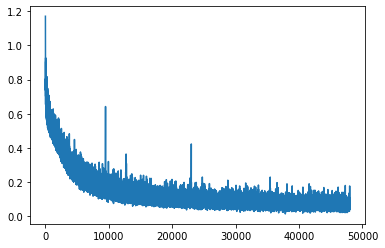

In [16]:
plt.plot(np.arange(epochs),losses)

In [17]:
torch.save(model, "/project/trlab/UNet_48000epochs_3e4_bcediceloss_affine_withBlur_batch4.pth")
print("done!")

done!
